In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("/Users/Yur/Downloads/ovitrap_data_with_province.csv", index_col=[0], usecols = ['date', 'id', 'value', 'adm'])

## Get a summary of the data per school, this makes the datacleaning more easy
    - Get schools with more than 50 observations, to have more reliable measurements
    - Filter schools with a maximum level that is less than 10 (very unlikely, probably misreporting)
    - Filter school with very high means (result of misreporting)
    - Filter schools with more than 50% 100's or 0's
    - Filter schools with only the same observations
    - Remove values that are between 0 and 1.5 as it is not plausible that a school has more than 60 ovitraps
    

In [2]:
summary_df = df.groupby(['id']).describe()

In [3]:
summary_df.columns = summary_df.columns.droplevel(0)

In [6]:
n = len(df)
sum_df = summary_df[summary_df['count'] > 40]
print(n-len(df[df['id'].isin(sum_df.index.tolist())]))
n = len(df[df['id'].isin(sum_df.index.tolist())])

# sum_df = sum_df[~(sum_df['max'] == sum_df['min'])] #removes 0
# print(n-len(df[df['id'].isin(sum_df.index.tolist())]))
# n = len(df[df['id'].isin(sum_df.index.tolist())])

sum_df = sum_df[sum_df['max'] > 10] 
print(n-len(df[df['id'].isin(sum_df.index.tolist())]))
n = len(df[df['id'].isin(sum_df.index.tolist())])

sum_df = sum_df[sum_df['mean'] < 90]
print(n-len(df[df['id'].isin(sum_df.index.tolist())]))
n = len(df[df['id'].isin(sum_df.index.tolist())])

# sum_df = sum_df[~((sum_df['50%']==100))]
# print(n-len(df[df['id'].isin(sum_df.index.tolist())]))
# n = len(df[df['id'].isin(sum_df.index.tolist())])

zeros_df = sum_df[~((sum_df['75%']==0) & (sum_df['max']==100))]
print(n-len(df[df['id'].isin(zeros_df.index.tolist())]))
n = len(df[df['id'].isin(zeros_df.index.tolist())])

zeros_df = zeros_df[~(zeros_df['75%']==zeros_df['max'])]
print(n-len(df[df['id'].isin(zeros_df.index.tolist())]))
n = len(df[df['id'].isin(zeros_df.index.tolist())])

zeros_df = zeros_df[~((zeros_df['mean']<2)&(zeros_df['max']>50))]
print(n-len(df[df['id'].isin(zeros_df.index.tolist())]))
n = len(df[df['id'].isin(zeros_df.index.tolist())])

print(n)

clean_school_df = (df[df['id'].isin(zeros_df.index.tolist())])

clean_df = clean_school_df[~((clean_school_df['value']>0) & (clean_school_df['value']<1.5))] # removes values 0<x<1.5
print(n-len(clean_df))
n=len(clean_df)
clean_df = clean_df[~((clean_df['value']<100) & (clean_df['value']>98.5))] # removes values 98.5<x<100
print(n-len(clean_df))
print(len(clean_df))

94464
1727
241
259
887
69
39409
198
6
39205


In [7]:
# Export DataFrame to csv file
export_csv = clean_df.to_csv('OviTrapData.csv') 
# S = semifiltered_df[['adm', 'id', 'value']].groupby(['adm', 'id']).describe()

## Create column that reports if a value occurs more than n (n=5) times in a row

In [20]:
# Import filtered dataset
df = pd.read_csv('OviTrapData.csv', parse_dates=['date'], usecols=['date', 'id', 'value', 'adm'])

In [54]:
i=0
sequence = np.zeros(len(df))
while i < len(df)-1:
    j = 1
    value = df.iloc[i, 2]
    value_id = df.iloc[i,1]
    next_value = df.iloc[i+j, 2]
    next_value_id = df.iloc[i+j, 1]
    
    while (next_value == value) and (next_value_id == value_id):
        next_value = df.iloc[i+j, 2]
        next_value_id = df.iloc[i+j, 1]
        j = j + 1
    
    if j > 6:
        sequence[i:(i+j-1)] = (j-1)
        i = i + j - 1
    else:
        i = i + 1
        
df['Recurring value'] = sequence

In [55]:
# adds the number of times a recurrent values occurs given that it occurs more than 5 times in a row
i=0
sequence = np.zeros(len(df))
df = df[['date', 'id', 'value', 'adm']]
while i < len(df)-1:
    j = 1
    value = df.iloc[i, 2]
    value_id = df.iloc[i,1]
    next_value = df.iloc[i+j, 2]
    next_value_id = df.iloc[i+j, 1]
    
    while (next_value == value) and (next_value_id == value_id):
        next_value = df.iloc[i+j, 2]
        next_value_id = df.iloc[i+j, 1]
        j = j + 1
    
    if j > 6:
        sequence[i:(i+j-1)] = (j-1)
        i = i + j - 1
    else:
        i = i + 1
        
df['Recurring value'] = sequence

In [62]:
# adds 1 if recurring values occur at the start of end of a schools observations

current_school  = df['id'][0]
first_last   = np.zeros(len(df))
#df = df.reset_index()

for i in range(len(df)):
    new_school = df['id'][i]

    if (current_school != new_school):
        amount_last = int(df['Recurring value'][i-1])
        amount_first = int(df['Recurring value'][i])
        if amount_last > 0:
            first_last[(i-amount_last):(i)] = 1
        
        if amount_first > 0:
            first_last[i:(i+amount_first)] = 1

    current_school = new_school

amount = int(df['Recurring value'][len(df)-1])
if amount > 0:
    first_last[-amount:] = 1
df['first_last'] = first_last
# get rid of recurring values at the start or end of school
df_check = df[((df['Recurring value']>0) & (df['first_last']>0))]
df = df[~((df['Recurring value']>0) & (df['first_last']>0))]
df = df.drop(columns = ['Recurring value', 'first_last'])

In [51]:
# clean_summary = df.groupby(['id'])['value', 'first_last'].describe()
# clean_summary.columns = clean_summary.columns.droplevel(0)
# clean_summary = clean_summary['mean']
# clean_summary.columns = ['mean_values', 'mean_recurrent']
# clean_summary = pd.DataFrame(clean_summary)
# check_df_id = clean_summary[(clean_summary['mean_values']>20) & (clean_summary['mean_recurrent'])].index.unique().tolist()

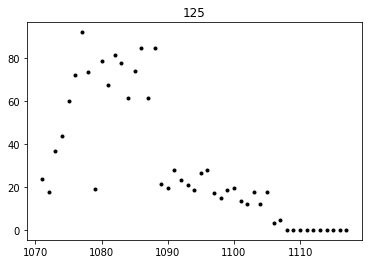

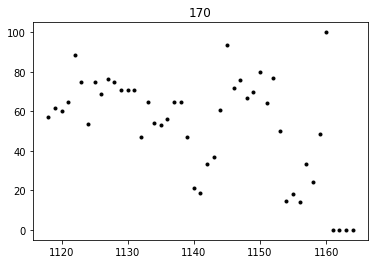

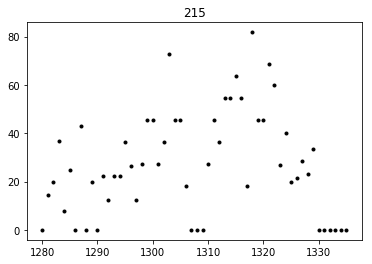

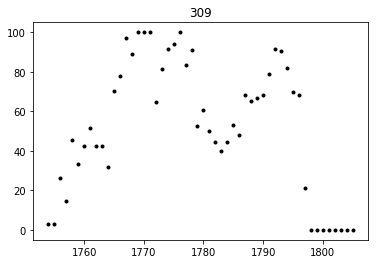

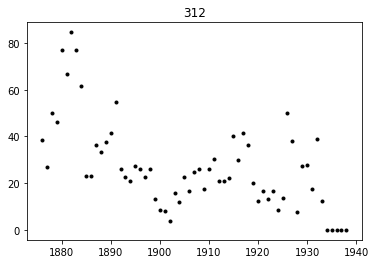

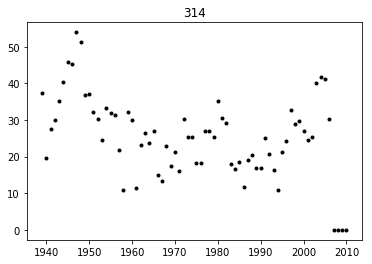

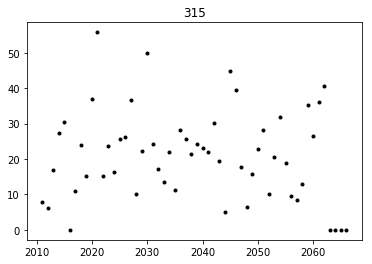

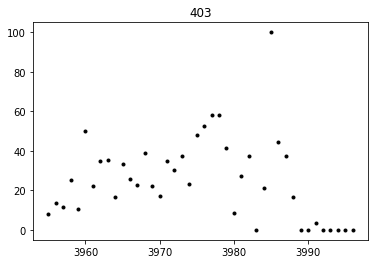

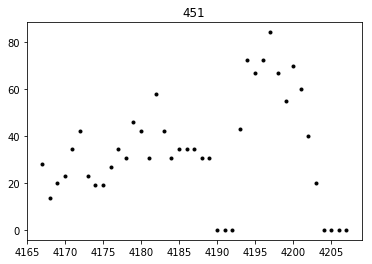

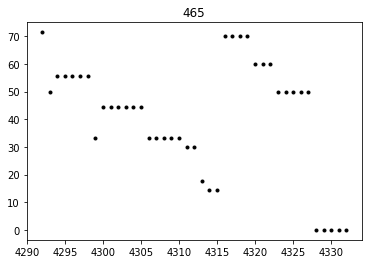

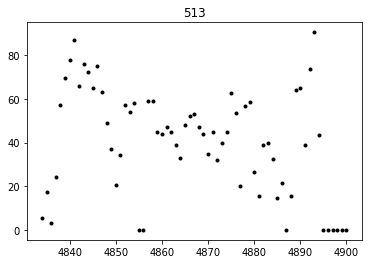

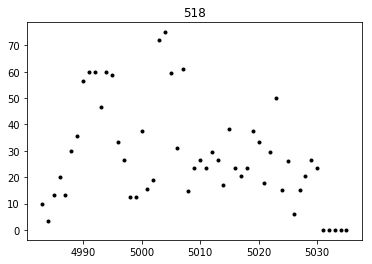

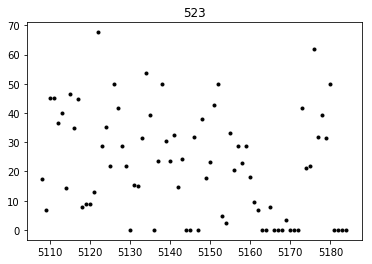

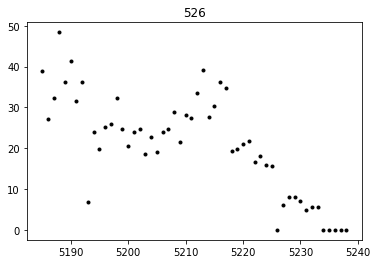

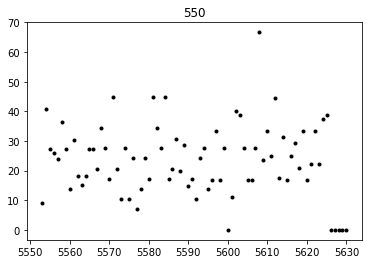

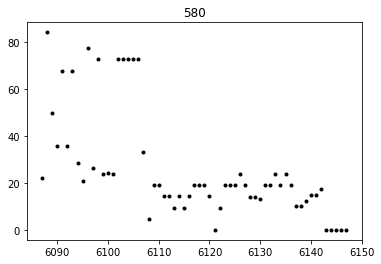

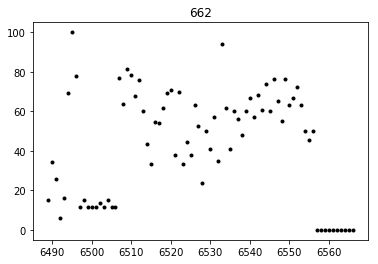

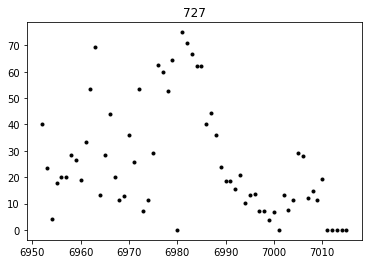

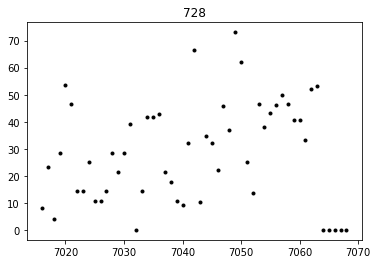

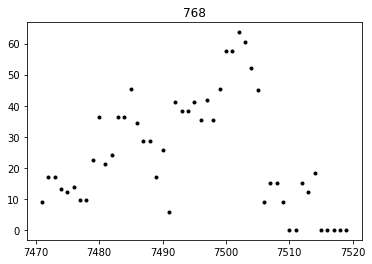

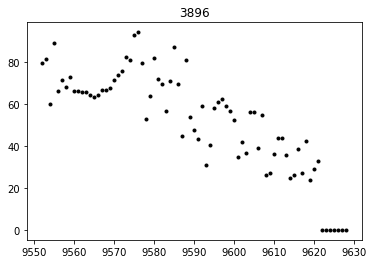

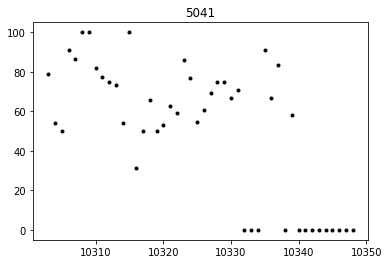

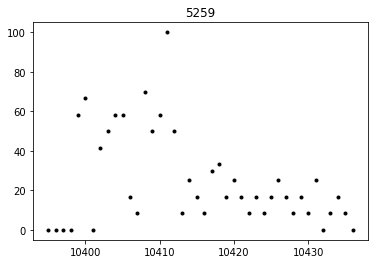

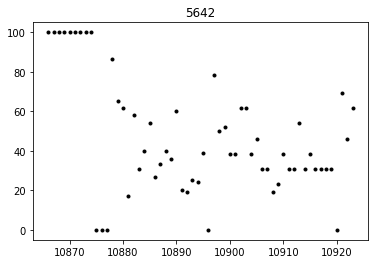

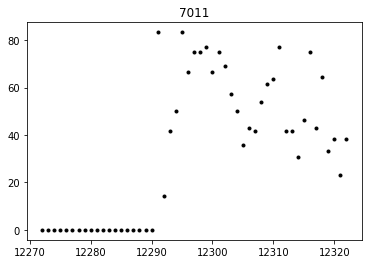

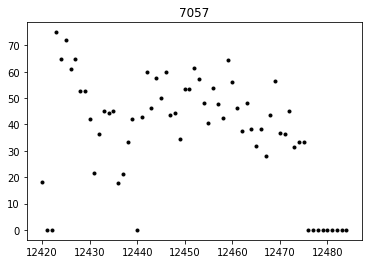

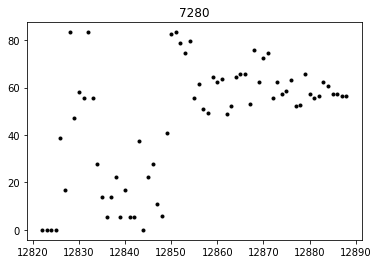

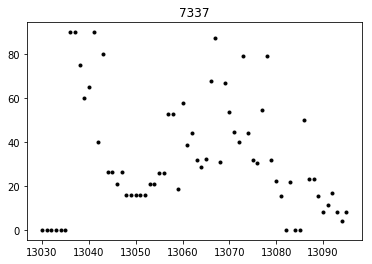

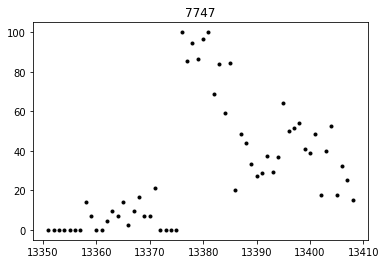

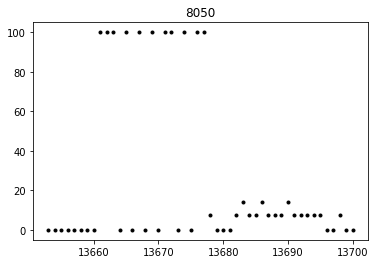

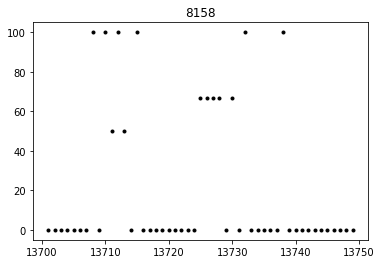

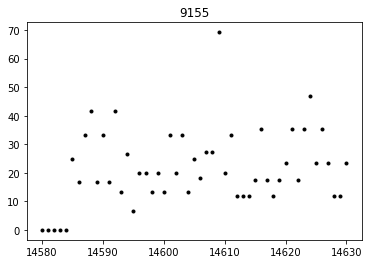

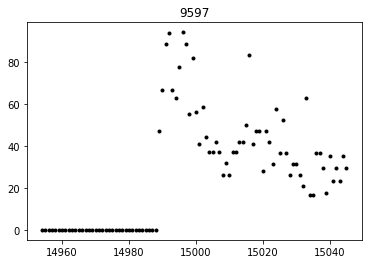

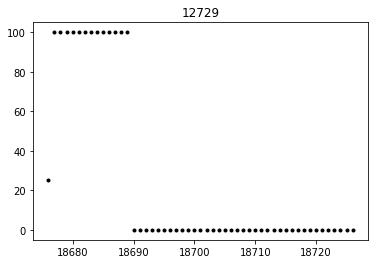

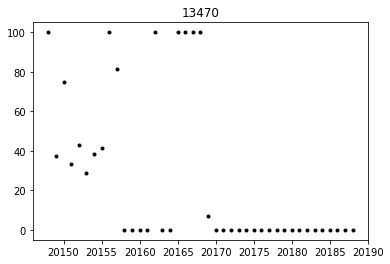

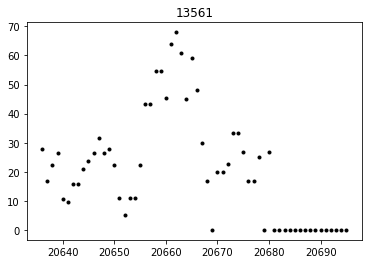

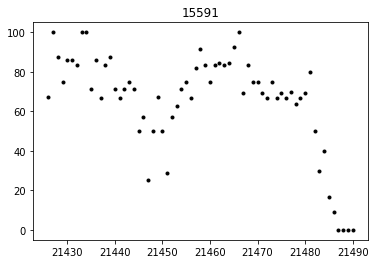

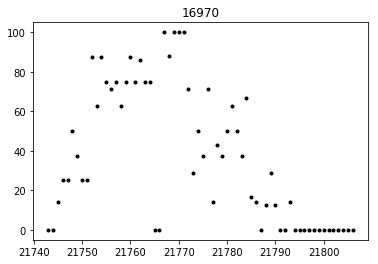

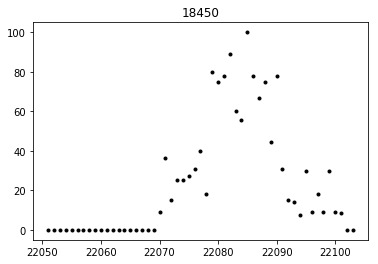

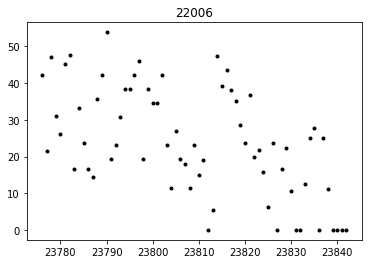

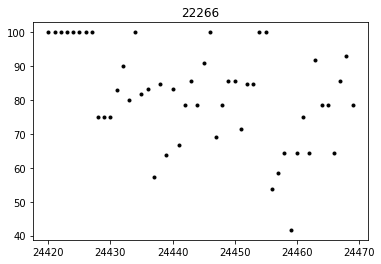

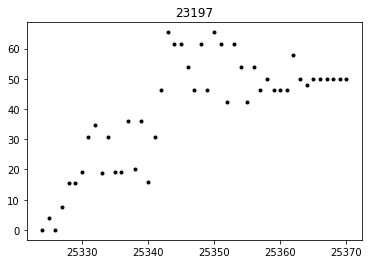

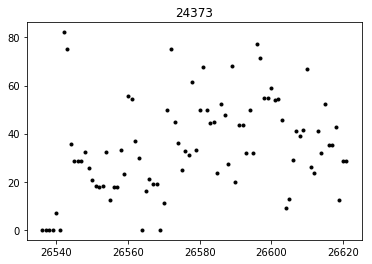

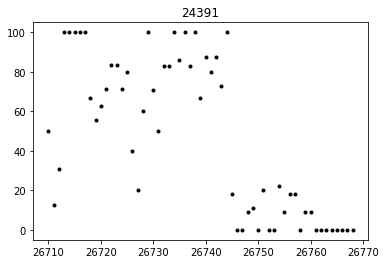

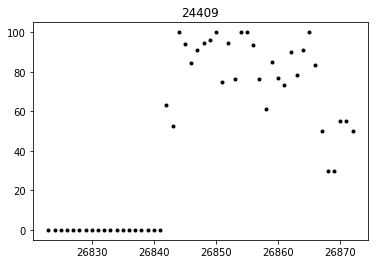

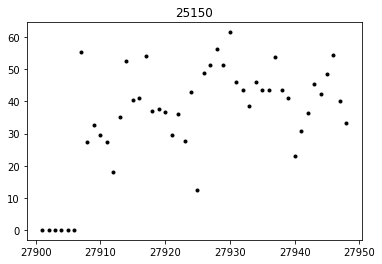

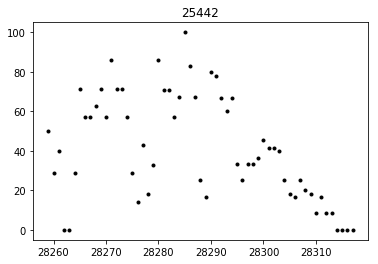

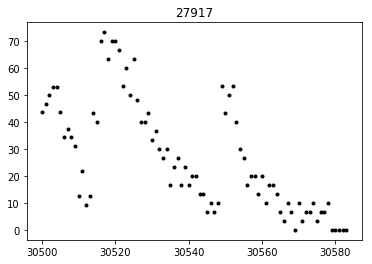

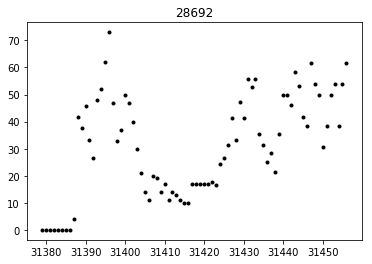

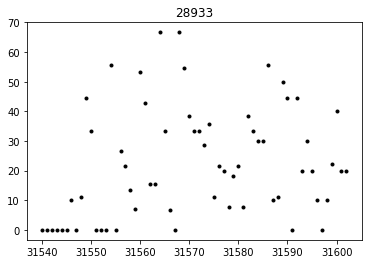

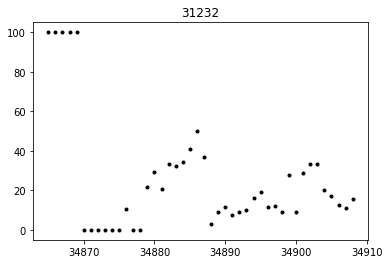

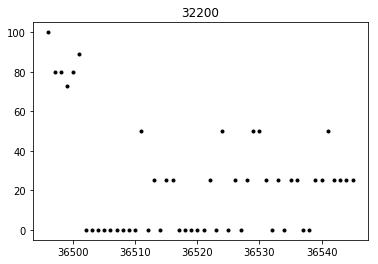

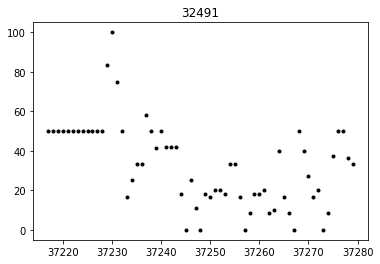

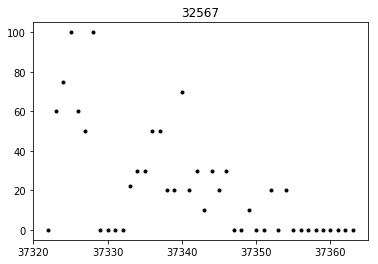

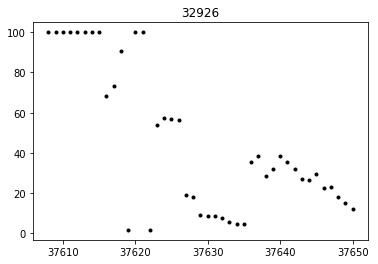

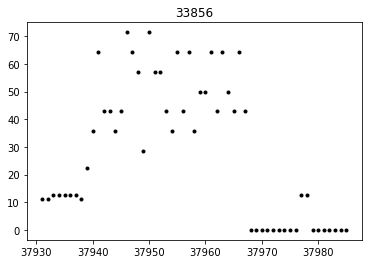

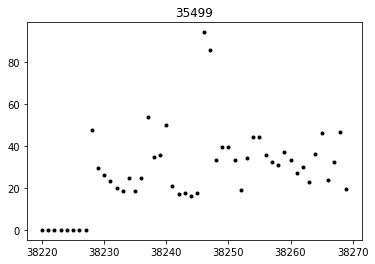

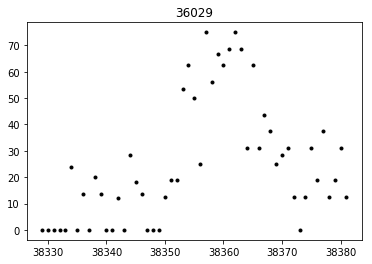

In [53]:
# from matplotlib import pyplot as plt
# %matplotlib inline
# # Plot OviTrap index per school for a certain district

# for school in df[df['id'].isin(check_df_id)]['id'].unique().tolist():
#     df_school = df[df['id'].isin(check_df_id)][df[df['id'].isin(check_df_id)]['id']==school]
#     df_school['value'].plot(style='k.')
#     plt.title(school)
#     plt.set_ylim=(0, 100)
#     plt.show()

In [63]:
df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'].dt.week
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [64]:
monthly_data = pd.DataFrame(df.groupby(['year', 'month', 'adm'])['value'].mean()).reset_index().sort_values(by=['adm', 'year'])
monthly_data['day'] = np.ones(len(monthly_data))
monthly_data['date'] = pd.to_datetime(monthly_data[['year', 'month', 'day']])
monthly_data = monthly_data.drop(columns=['year', 'month','day'])
month_fill = monthly_data.groupby(['adm', 'date']).sum()

In [65]:
adm_levels = df.adm.unique()
months = pd.date_range(start='1/1/2013', end='1/12/2016', freq='MS') 
df_final = pd.DataFrame(index=pd.MultiIndex.from_product([adm_levels, months],
                                                         names=['adm', 'date']))
df_final['value'] = 0.
df_final.head()

value
adm                  date             
NCR, Fourth District 2013-01-01    0.0
                     2013-02-01    0.0
                     2013-03-01    0.0
                     2013-04-01    0.0
                     2013-05-01    0.0

In [66]:
aggregated_month = df_final.add(month_fill, fill_value=0).reset_index()

In [68]:
df.groupby(['adm', 'id'])['value'].mean()

adm                  id   
Abra                 24379    50.593478
                     24391    54.551961
                     24409    77.417742
                     24780    55.971406
                     25336    44.041220
                     25471    24.341803
                     25484    37.633125
                     25499    65.101628
                     28323    19.941628
                     28425    75.055789
                     29344    46.646667
                     30151     7.926000
Agusan del Norte     36591    60.559592
Albay                1036     25.392857
                     1055     48.366237
                     1098     20.635492
                     1147     36.935536
                     1229     25.710658
                     1233     59.284096
                     1727     37.530345
                     1950     24.246184
                     5548     54.260708
                     5570     17.593774
                     5652     37.323284
             

In [70]:
provinces = df.adm.unique().tolist()
#make a dictionary, place means in this dictionary
for province in provinces:
    df_province = df[df['adm']==province]
    n_schools = len(df_province['id'].unique().tolist())
    np.zeros(n_schools)
    for school in df_province['id'].unique().tolist():
        df_school = df_province[df_province['id']==school]
    print(province, ' #schools = ', n_schools)

NCR, Fourth District  #schools =  43
NCR, City of Manila, First District  #schools =  13
NCR, Second District  #schools =  26
NCR, Third District  #schools =  38
Bulacan  #schools =  30
Albay  #schools =  20
Aurora  #schools =  5
Leyte  #schools =  10
Compostela Valley  #schools =  11
Negros Occidental  #schools =  1
Davao del Sur  #schools =  12
Camarines Sur  #schools =  8
Iloilo  #schools =  5
Marinduque  #schools =  11
Zamboanga Sibugay  #schools =  6
Occidental Mindoro  #schools =  2
Zamboanga del Sur  #schools =  10
Cavite  #schools =  16
Oriental Mindoro  #schools =  6
Romblon  #schools =  4
Nueva Ecija  #schools =  19
Masbate  #schools =  9
Sorsogon  #schools =  8
Cebu  #schools =  11
Bataan  #schools =  11
Tarlac  #schools =  9
Batangas  #schools =  33
Zambales  #schools =  6
Pampanga  #schools =  11
Bukidnon  #schools =  5
Zamboanga del Norte  #schools =  12
Quezon  #schools =  31
Negros Oriental  #schools =  5
Siquijor  #schools =  2
Laguna  #schools =  27
Isabela  #schools 

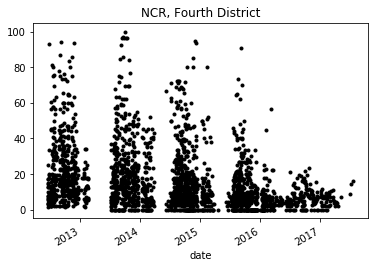

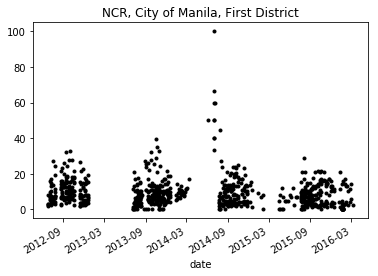

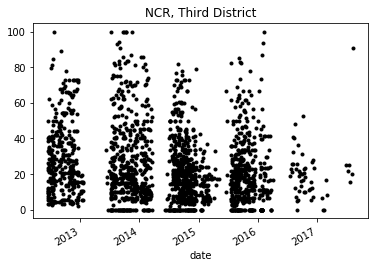

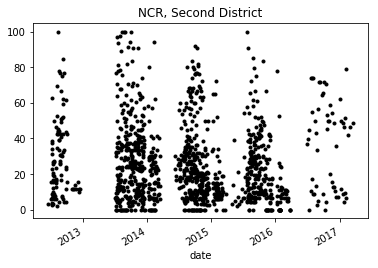

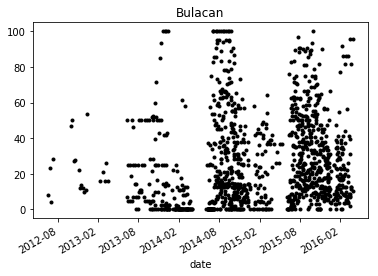

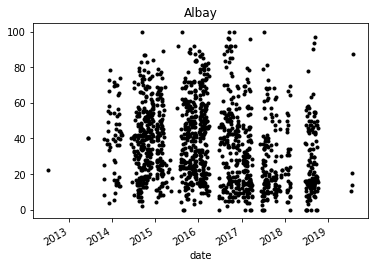

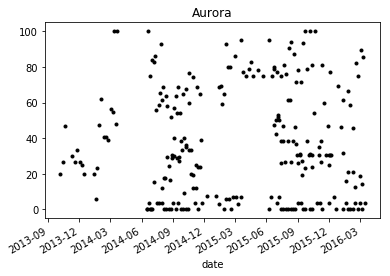

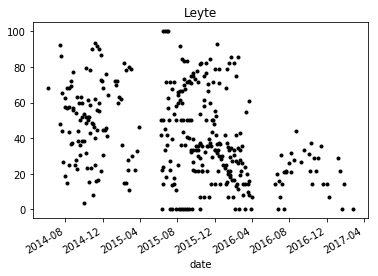

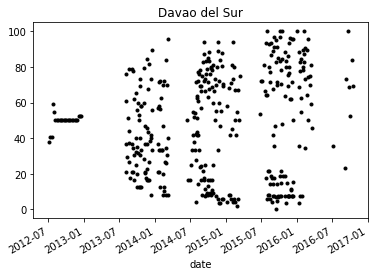

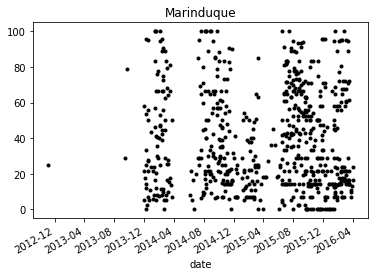

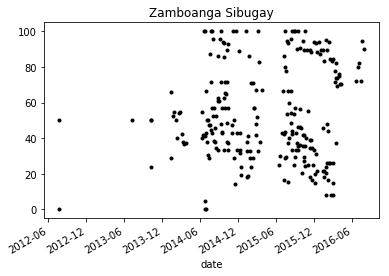

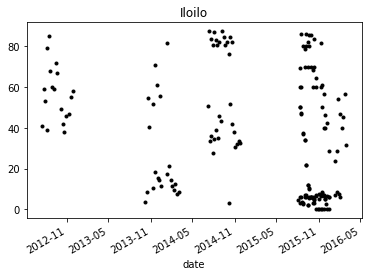

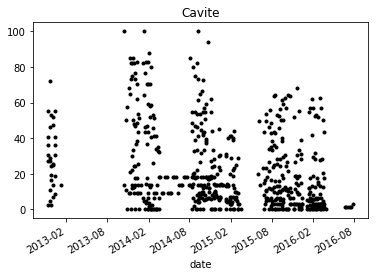

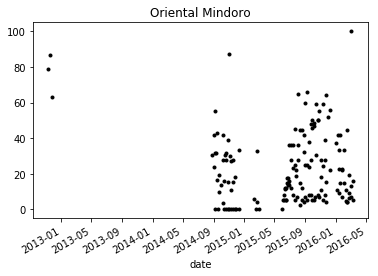

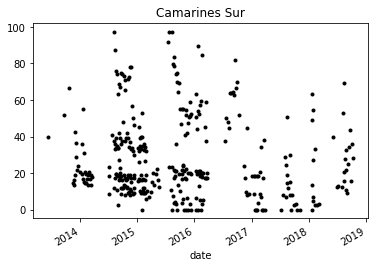

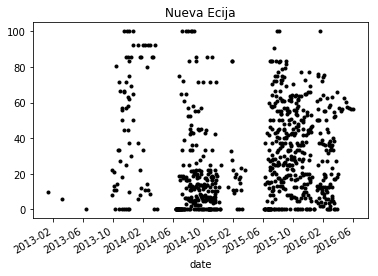

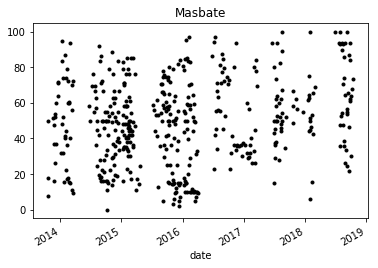

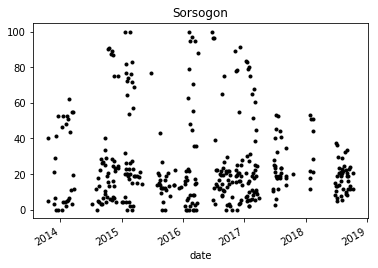

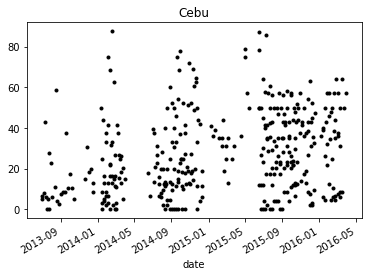

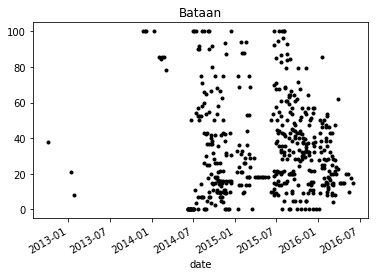

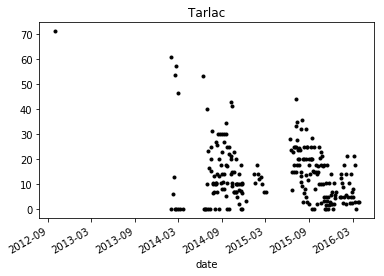

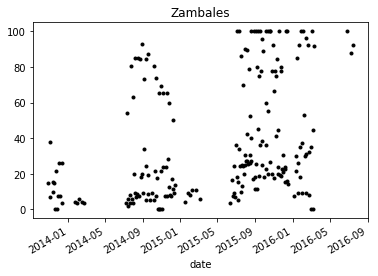

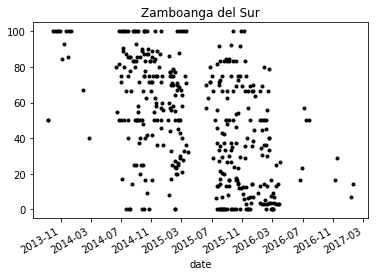

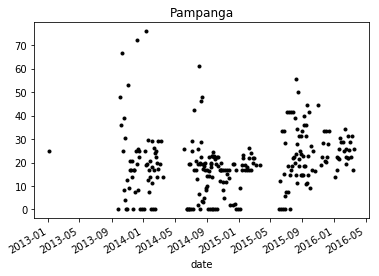

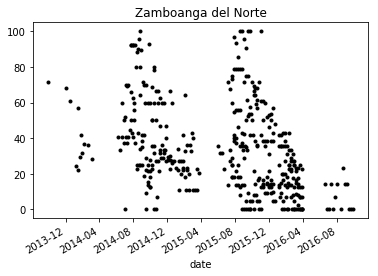

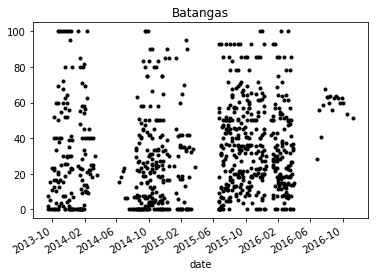

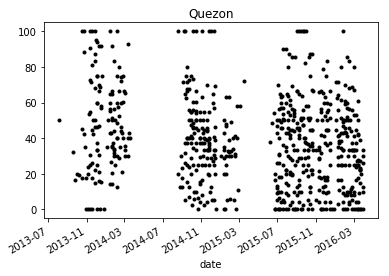

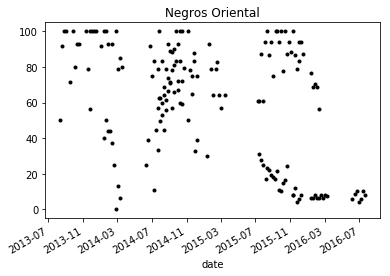

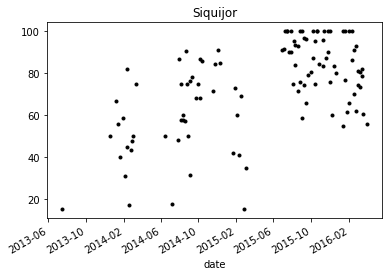

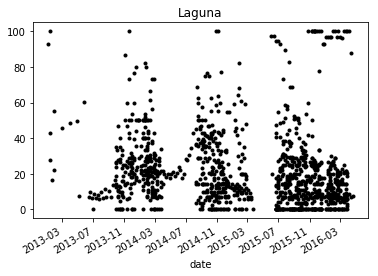

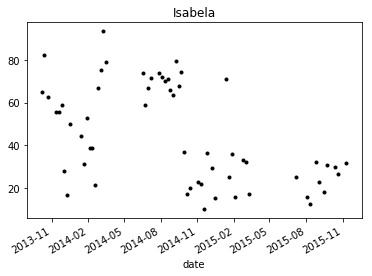

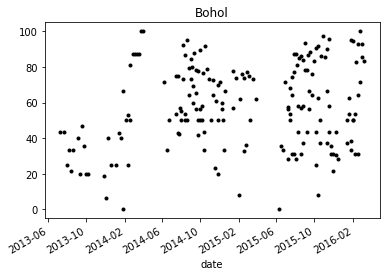

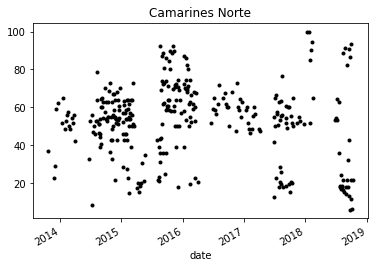

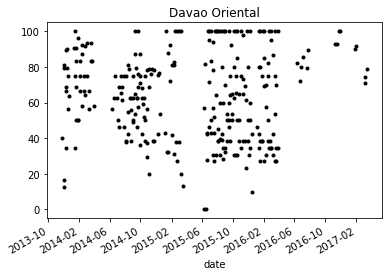

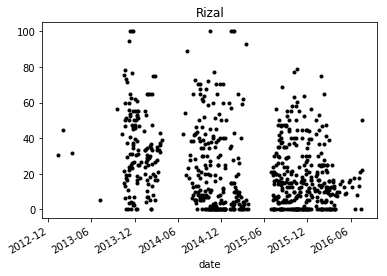

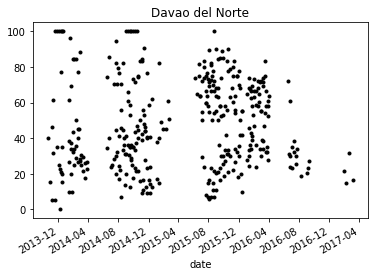

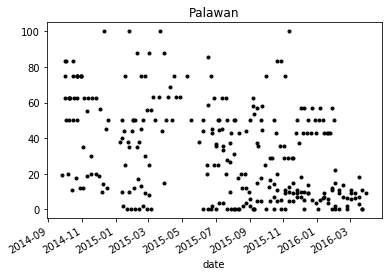

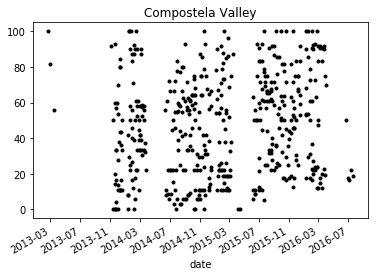

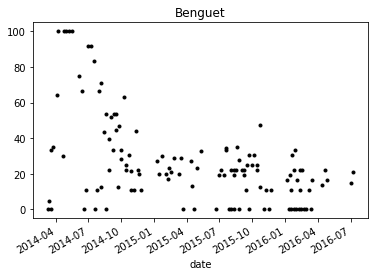

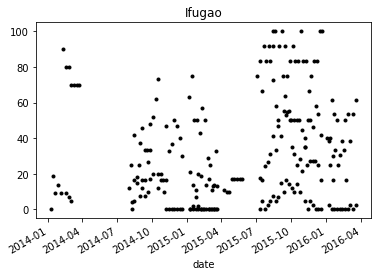

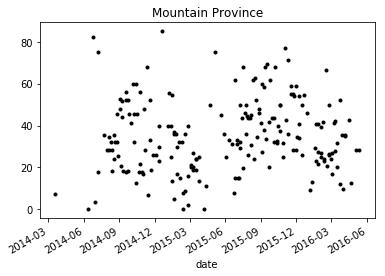

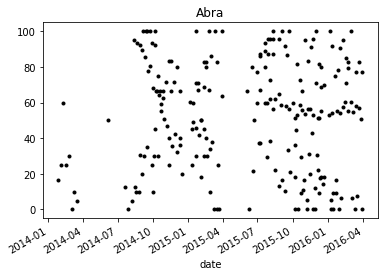

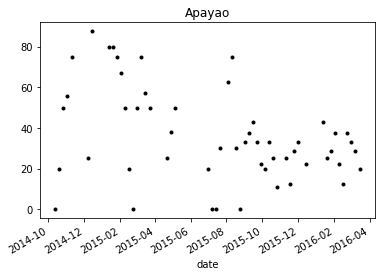

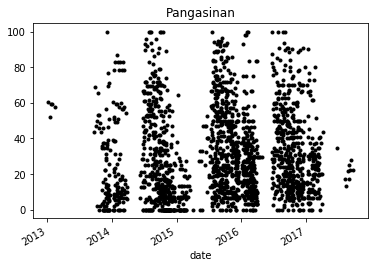

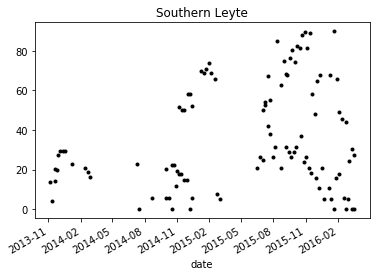

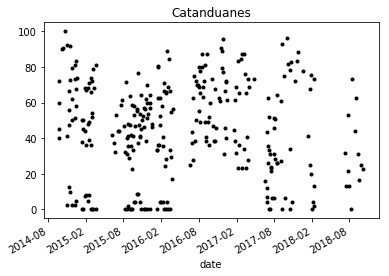

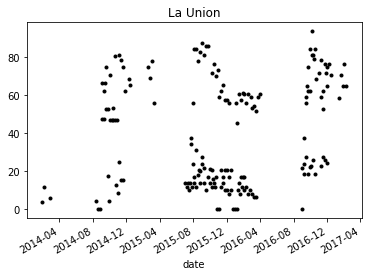

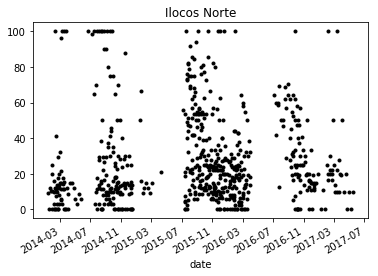

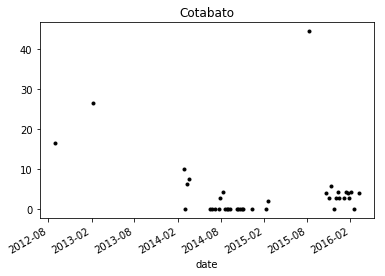

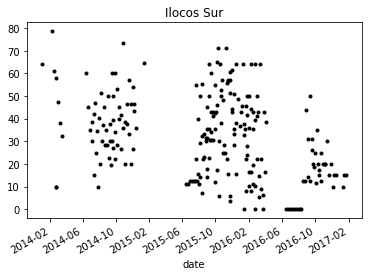

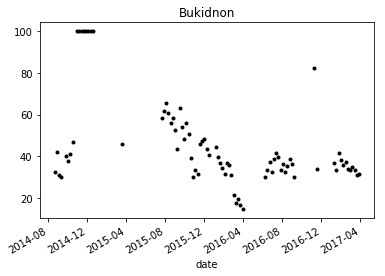

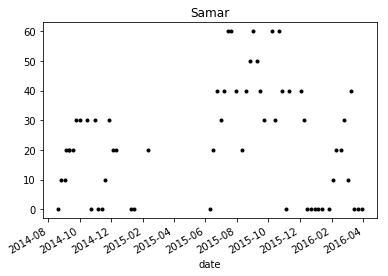

Number of missing provinces:  0


In [33]:
from matplotlib import pyplot as plt

adm_list = df['adm'].unique().tolist()
i = 0
for province in provinces:
    df_test = df[df['adm']==province]
    df_test = df_test.set_index(['date'])
    try:
        df_test['value'].plot(style='k.')
        plt.title(province)
        plt.show()
    except:
        print("An exception occurred")
        i= i +1 
print('Number of missing provinces: ', i)

In [73]:
export_csv = month_fill.to_csv('monthly_mosquito_per_province.csv') 

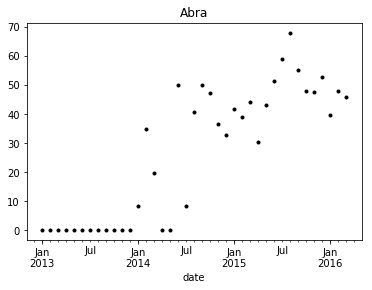

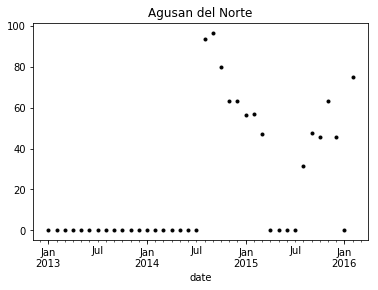

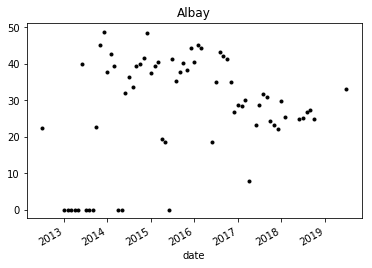

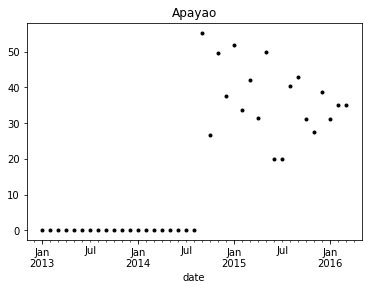

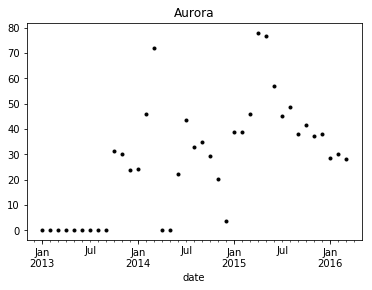

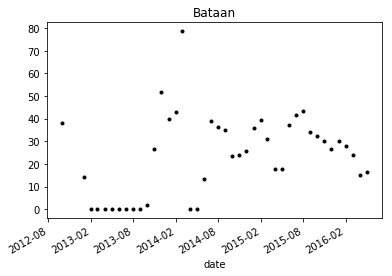

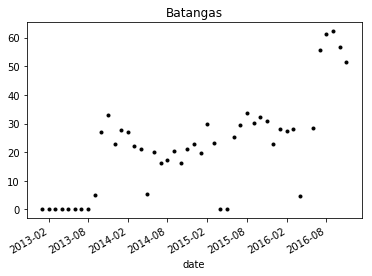

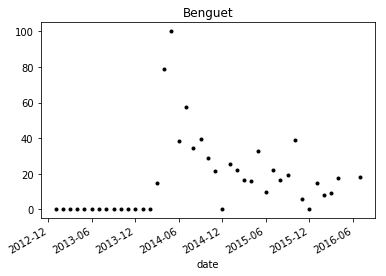

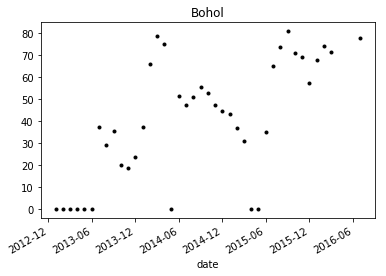

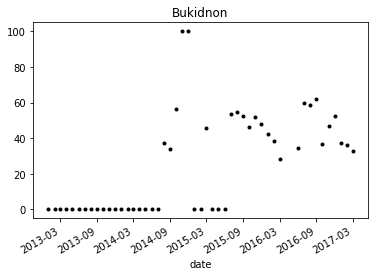

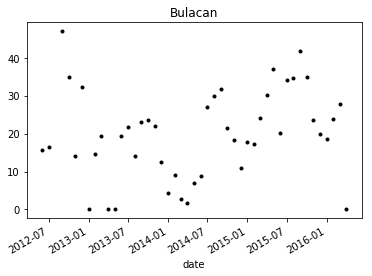

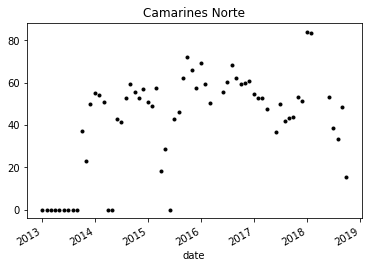

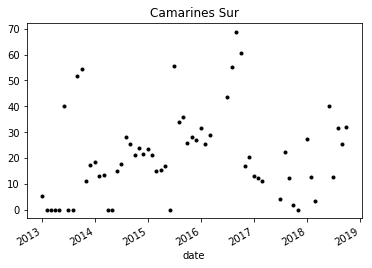

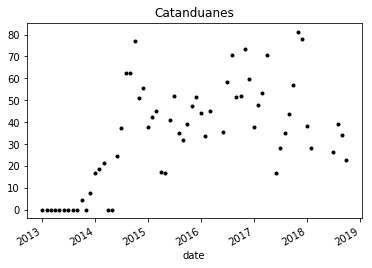

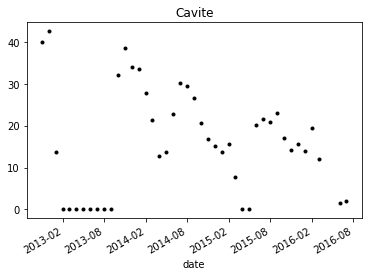

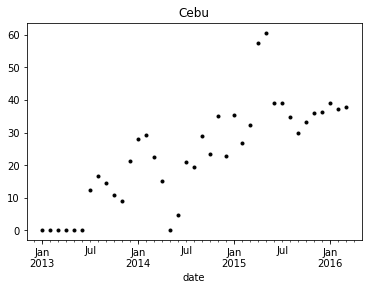

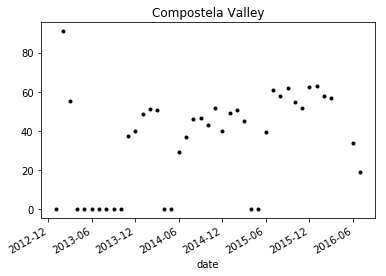

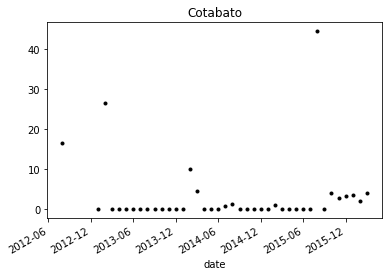

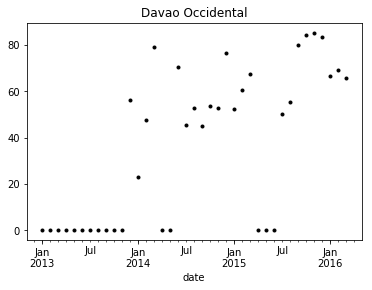

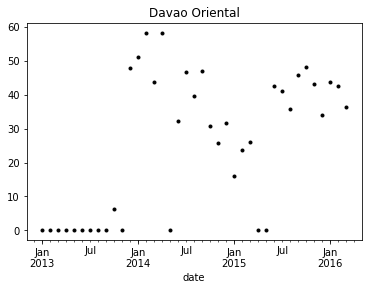

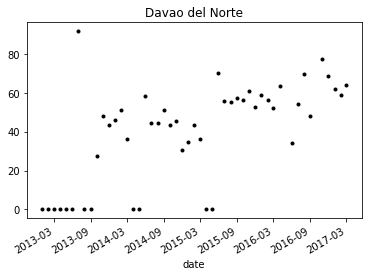

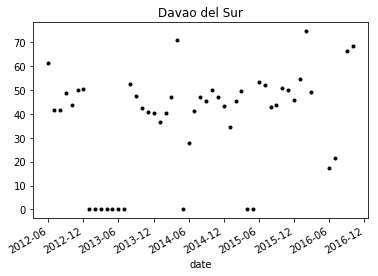

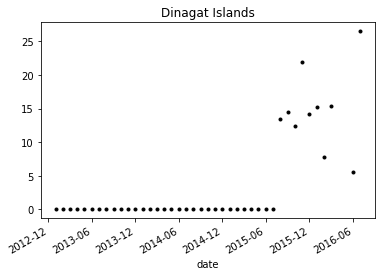

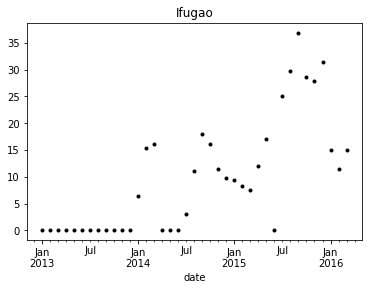

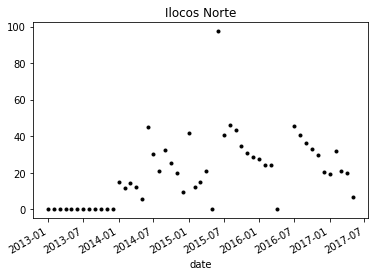

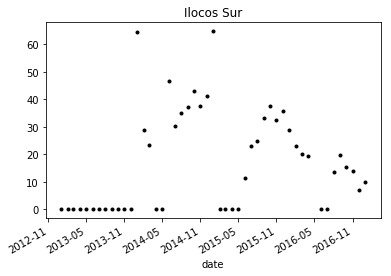

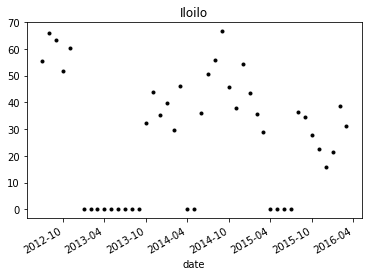

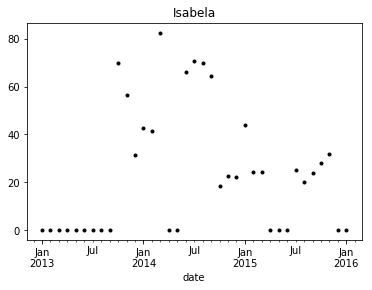

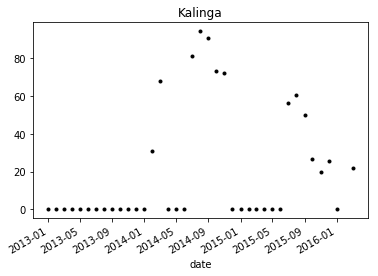

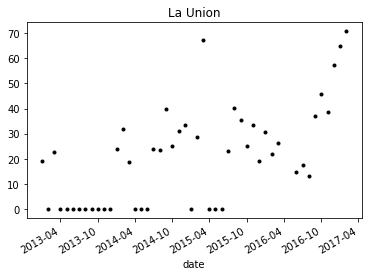

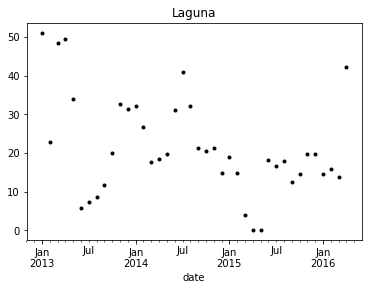

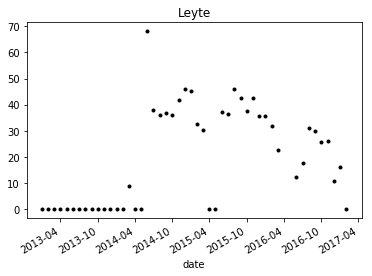

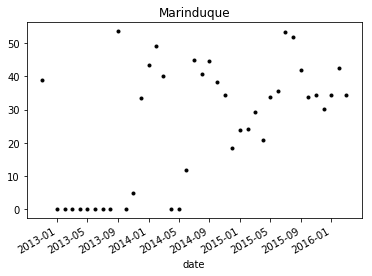

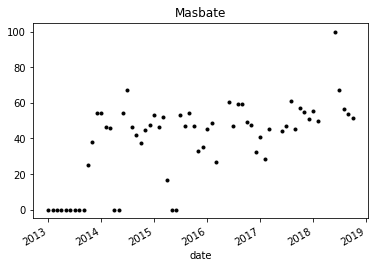

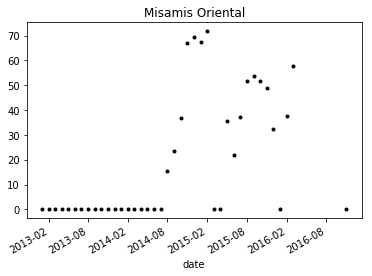

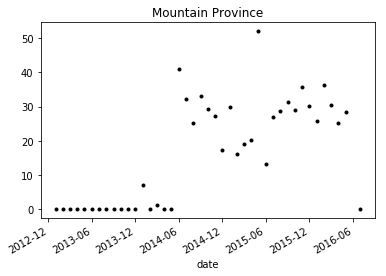

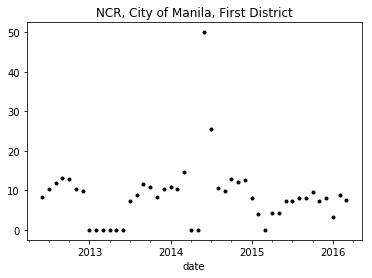

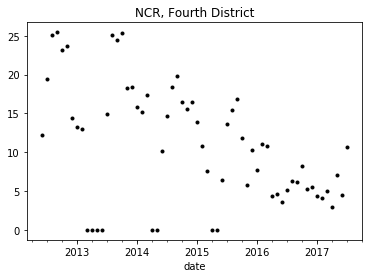

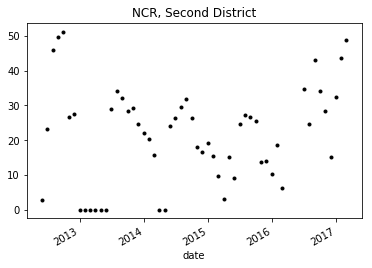

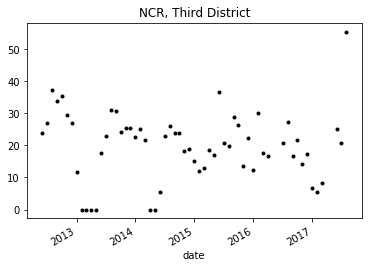

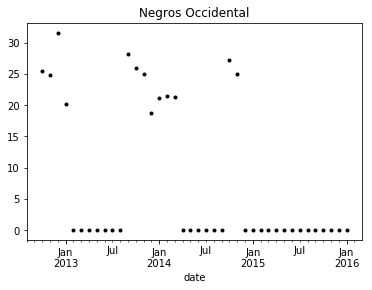

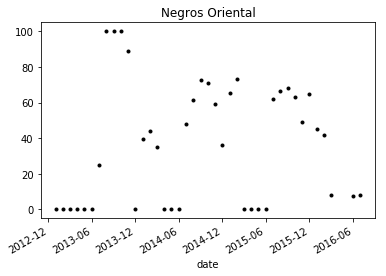

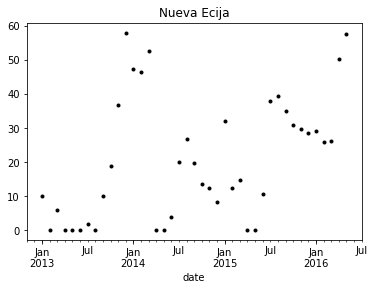

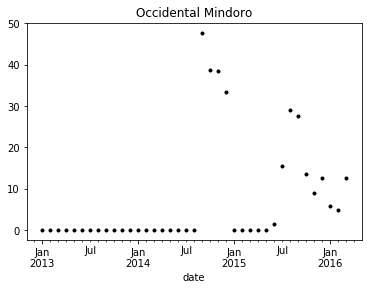

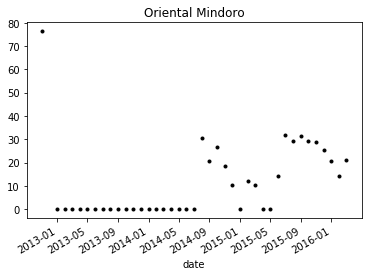

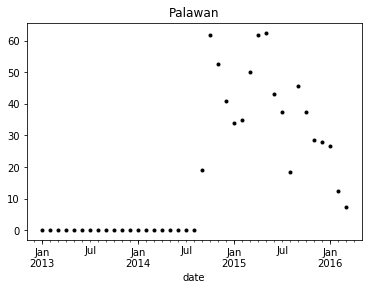

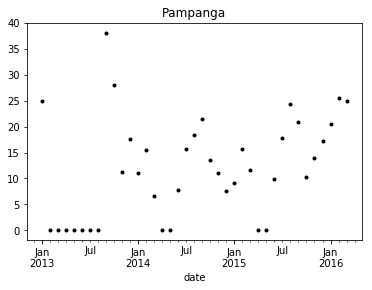

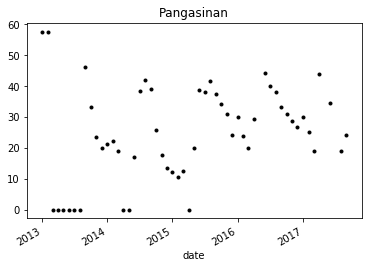

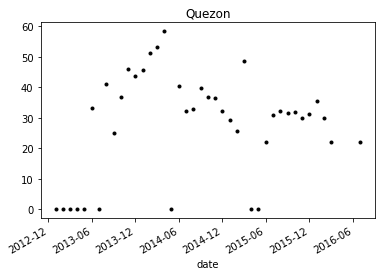

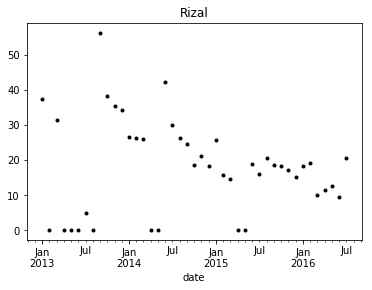

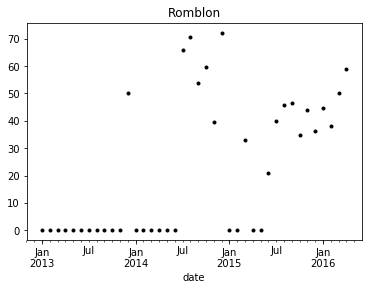

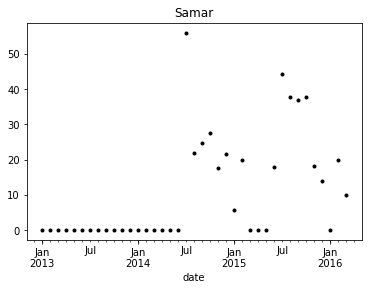

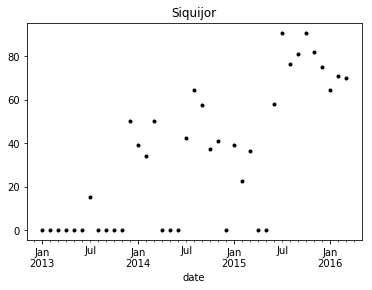

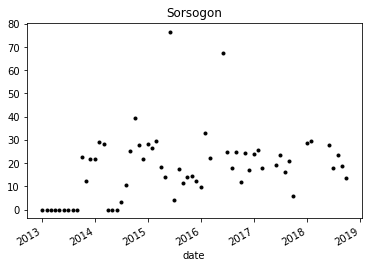

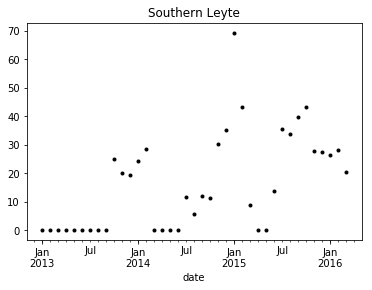

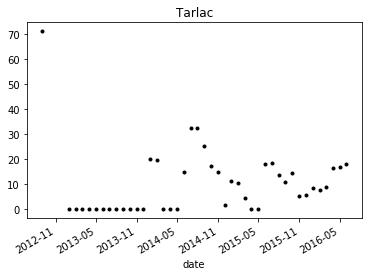

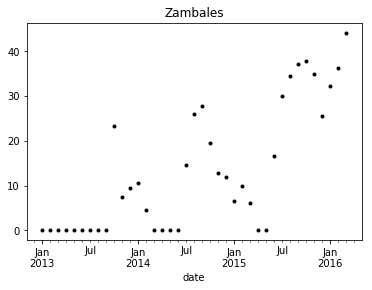

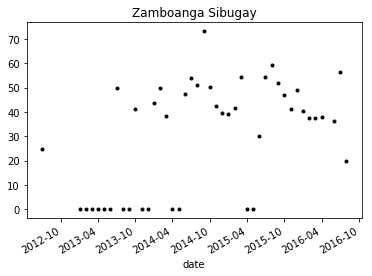

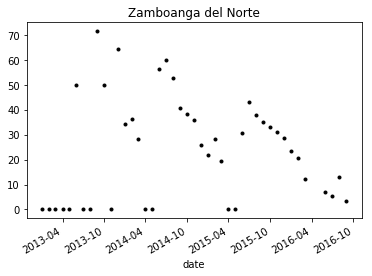

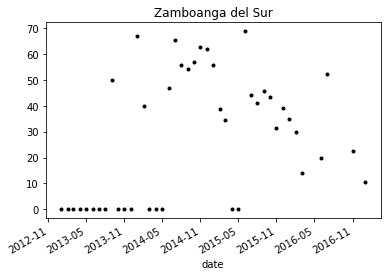

Number of missing provinces:  0


In [74]:
# plots of all aggregated monthly data per province
from matplotlib import pyplot as plt
%matplotlib inline
adm_list = aggregated_month['adm'].unique().tolist()
aggregated_month['date'] = pd.to_datetime(aggregated_month['date'])

i = 0
for province in adm_list:
    df_test = aggregated_month[aggregated_month['adm']==province]
    df_test = df_test.set_index(['date'])
    try:
        df_test.value.plot(style='k.')
        plt.title(province)
        plt.show()
    except:
        print("An exception occurred")
        i= i +1 
print('Number of missing provinces: ', i)

In [16]:
export_csv = aggregated_month.to_csv('aggregated_monthly.csv') 

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline
# Plot OviTrap index per school for a certain district

for school in recurring_df['id'].unique().tolist():
    df_school = recurring_df[recurring_df['id']==school]
    df_school['value'].plot(style='k.')
    plt.title(school)
    plt.set_ylim=(0, 100)
    plt.show()

NameError: name 'recurring_df' is not defined

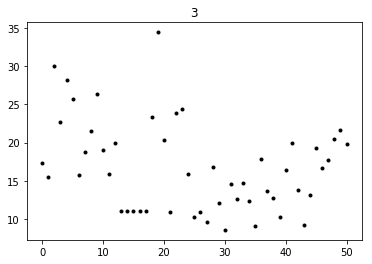

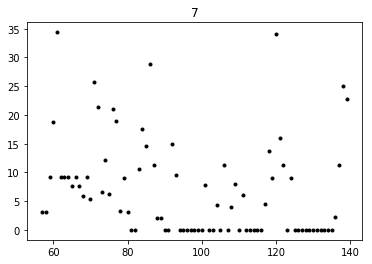

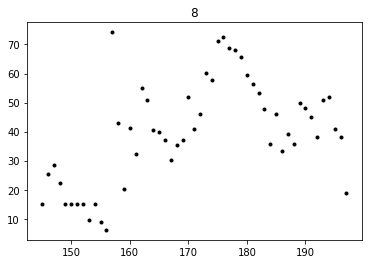

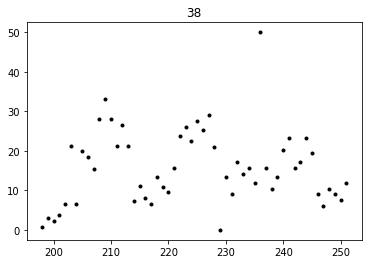

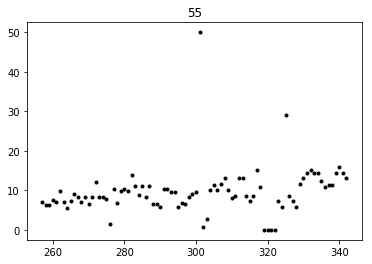

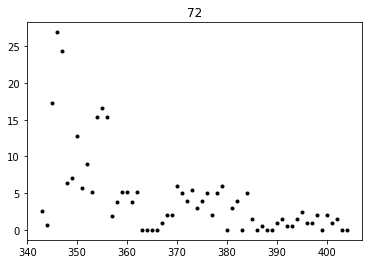

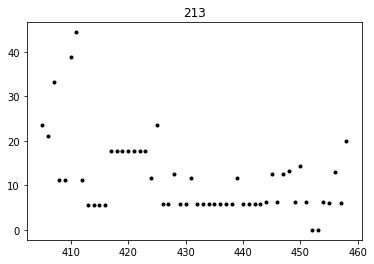

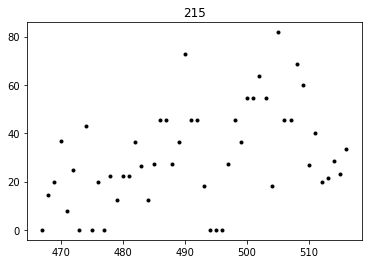

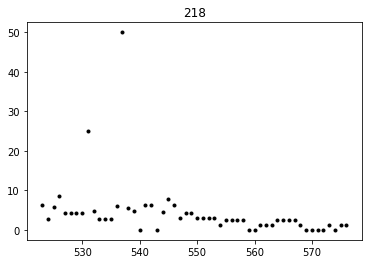

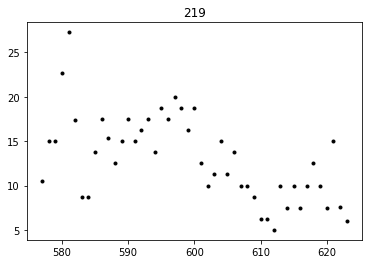

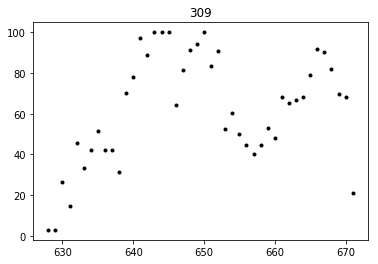

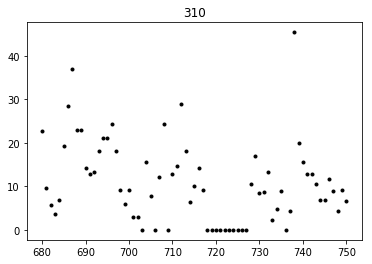

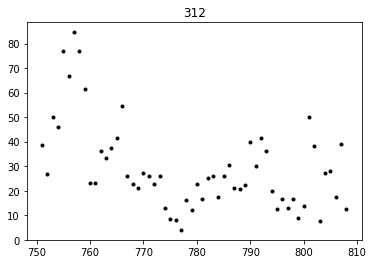

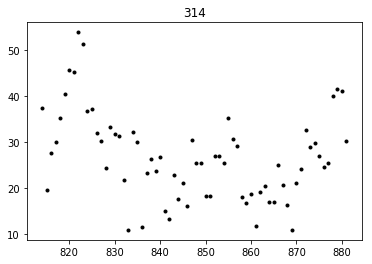

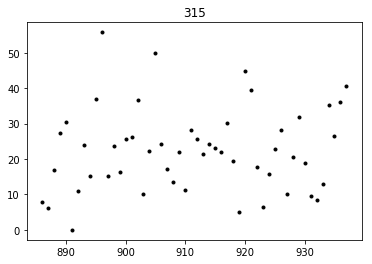

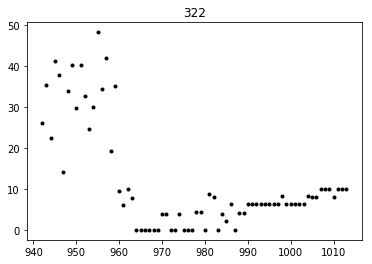

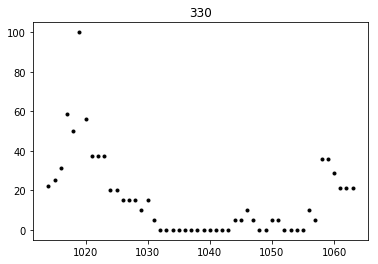

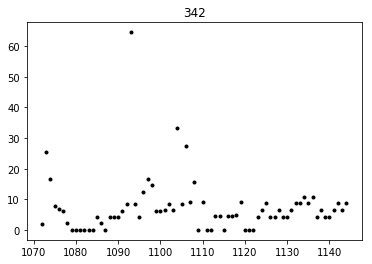

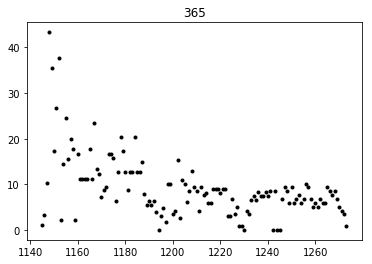

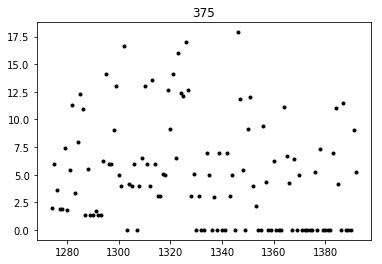

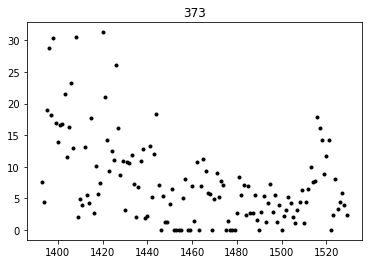

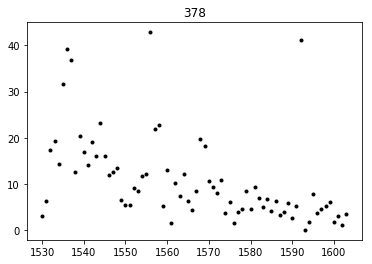

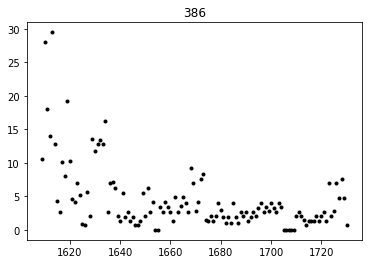

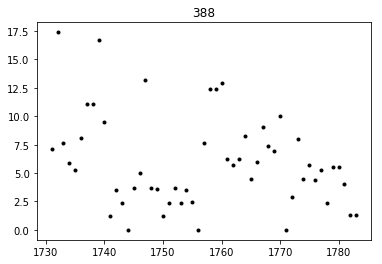

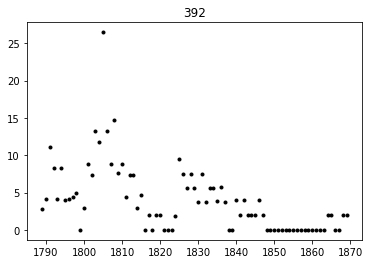

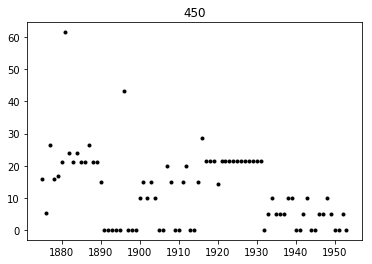

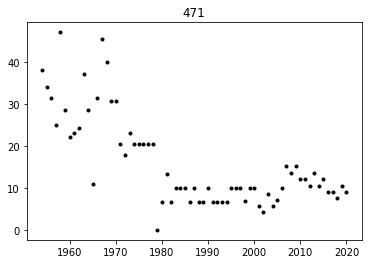

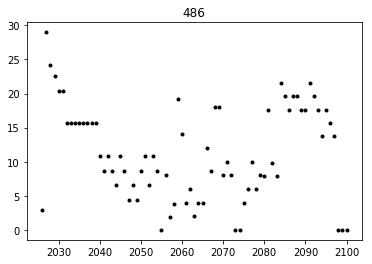

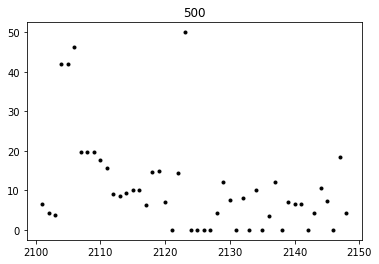

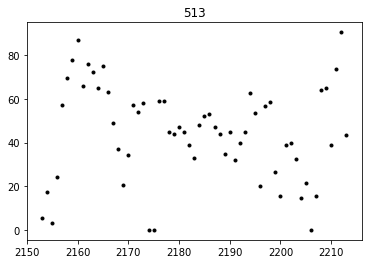

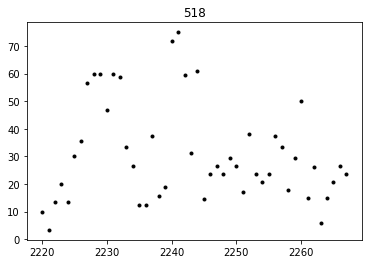

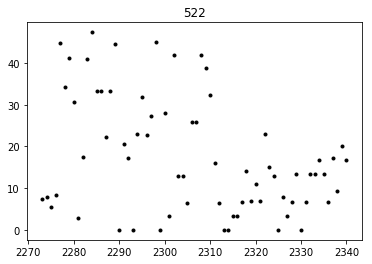

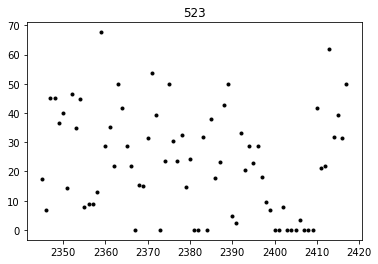

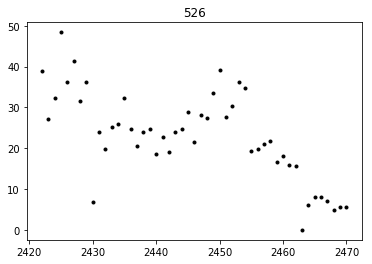

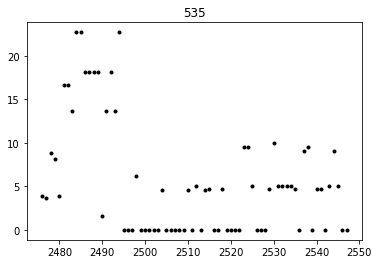

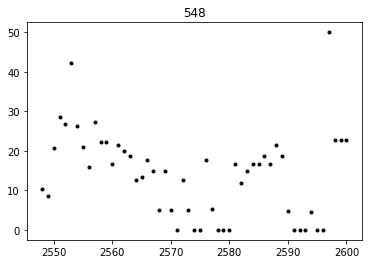

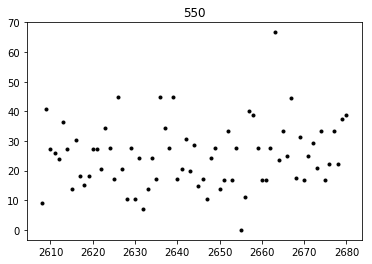

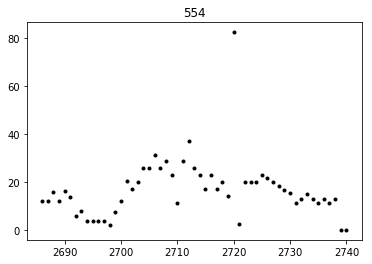

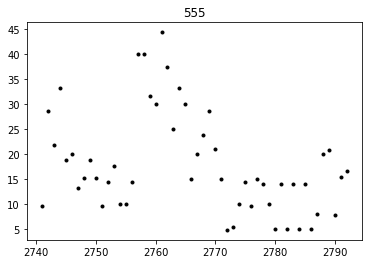

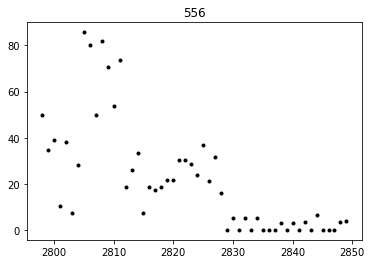

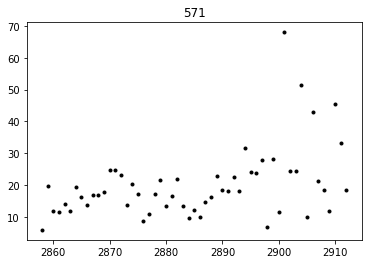

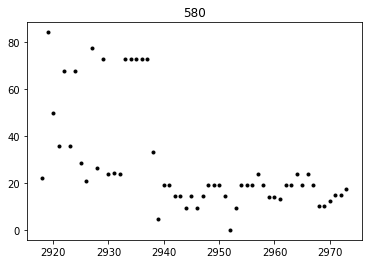

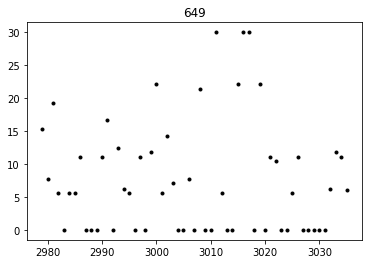

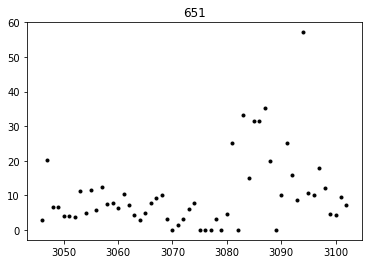

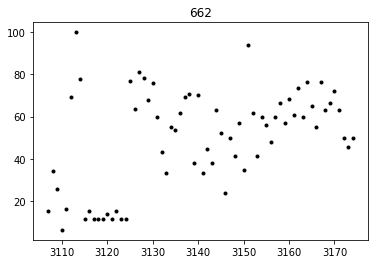

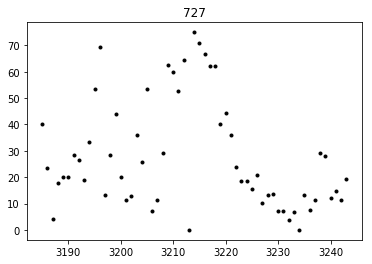

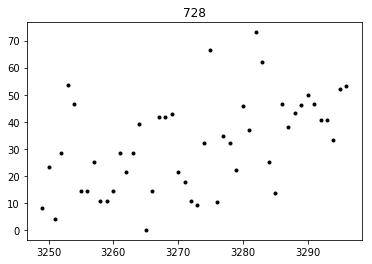

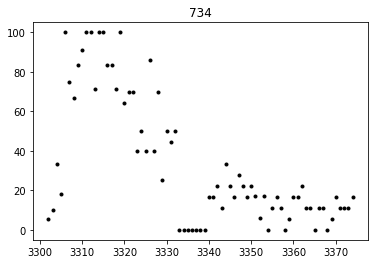

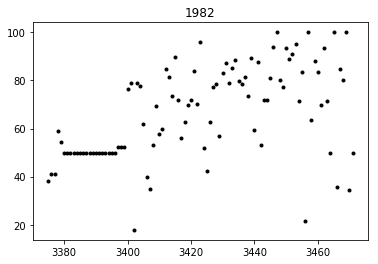

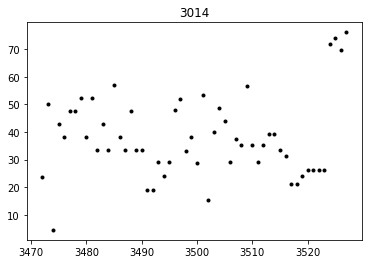

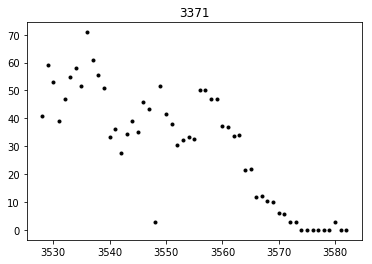

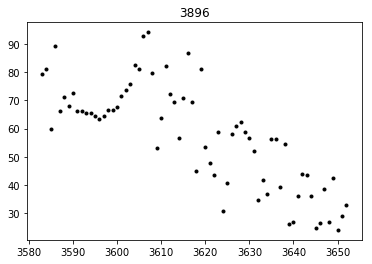

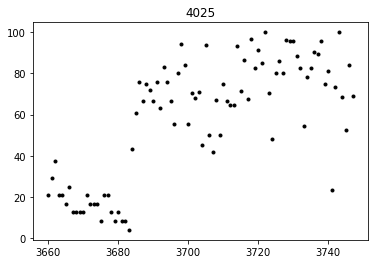

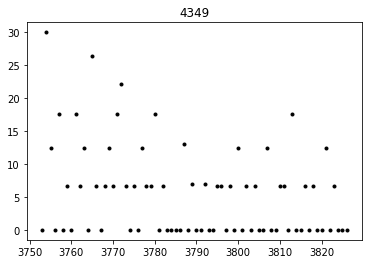

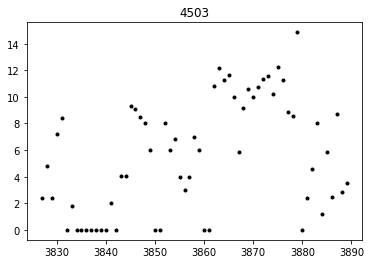

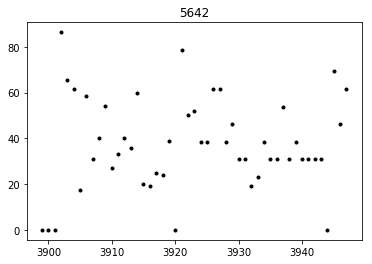

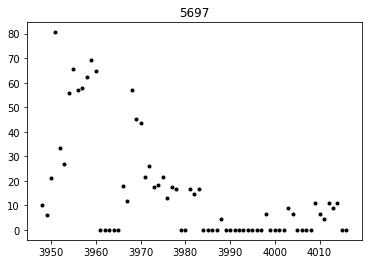

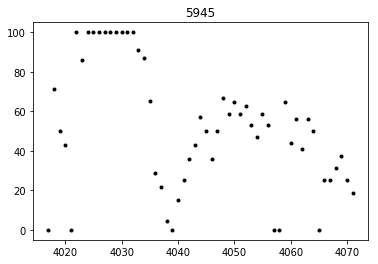

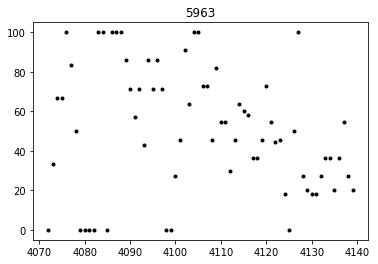

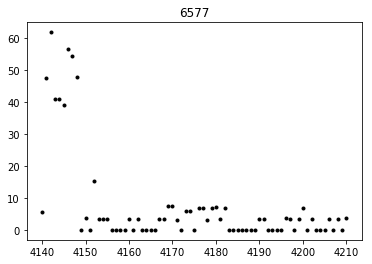

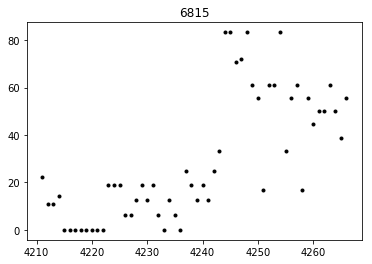

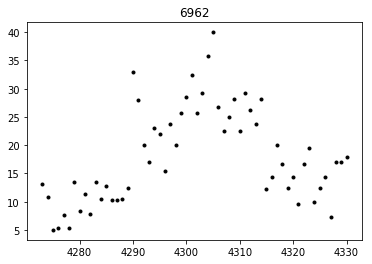

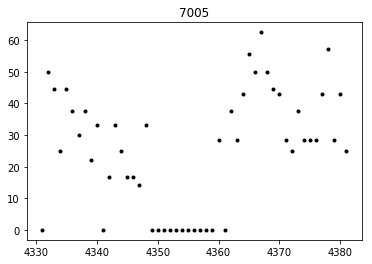

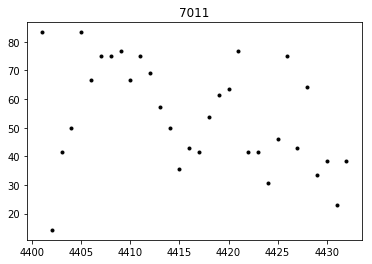

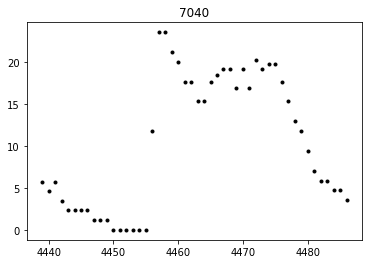

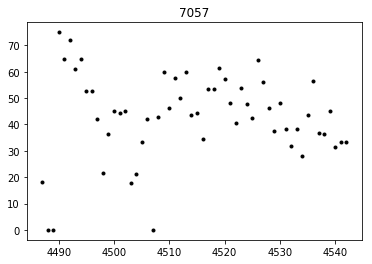

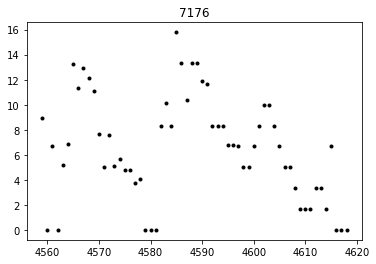

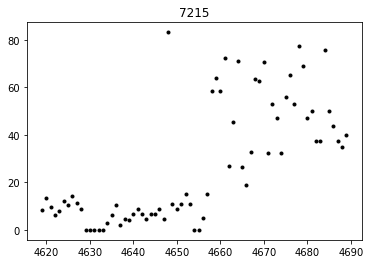

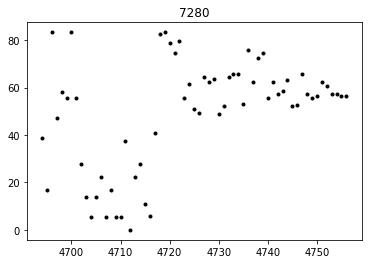

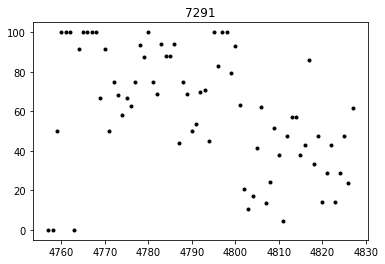

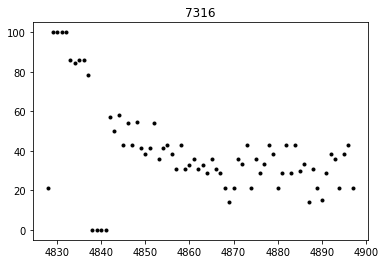

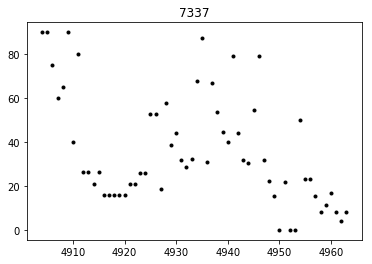

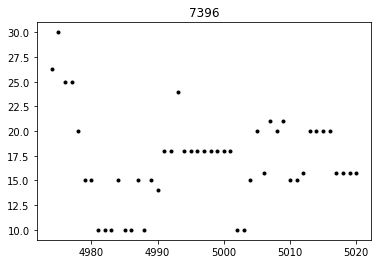

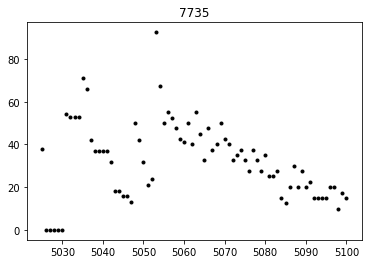

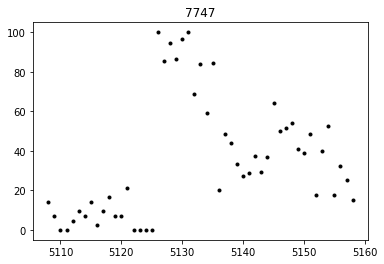

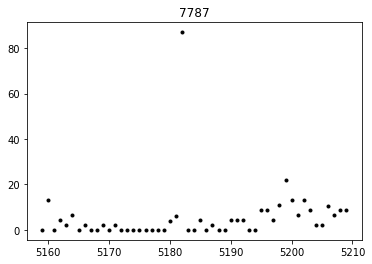

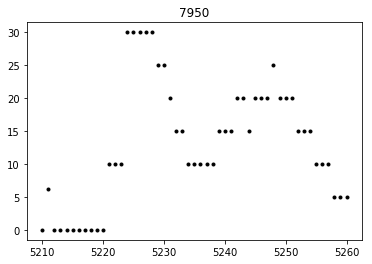

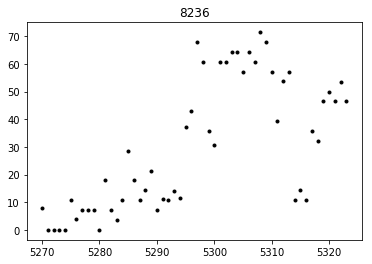

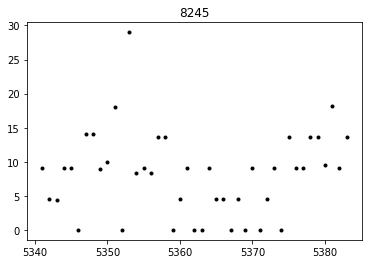

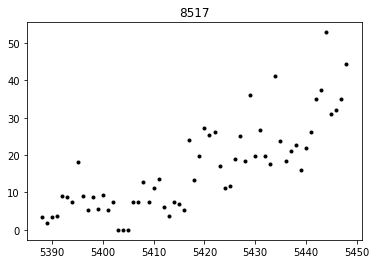

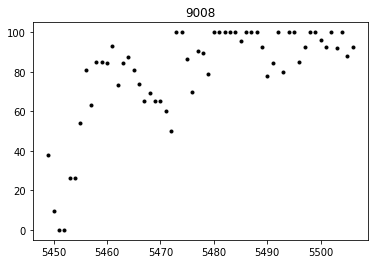

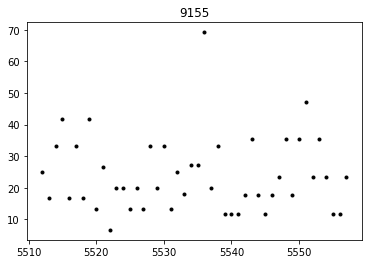

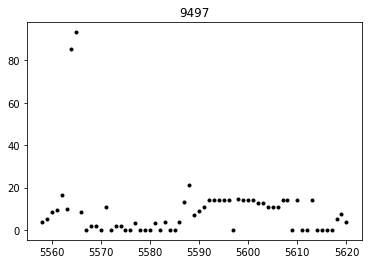

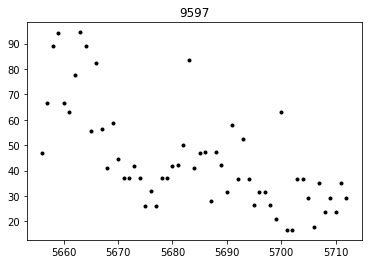

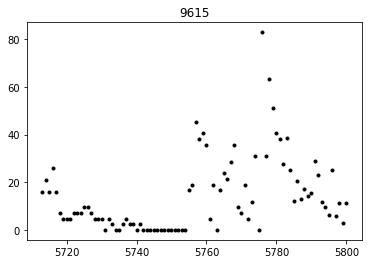

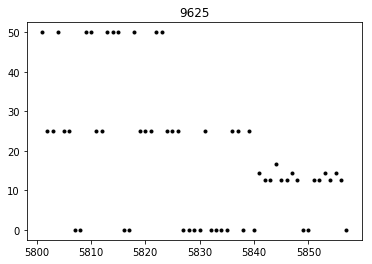

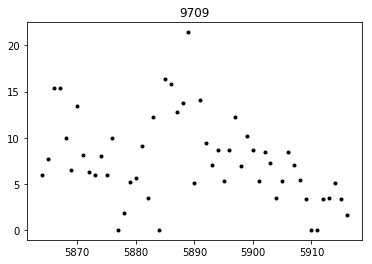

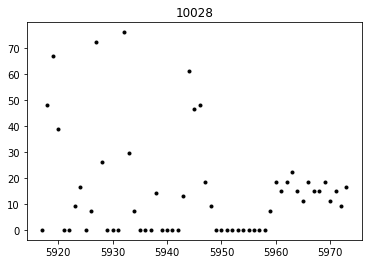

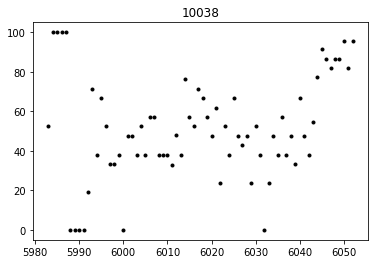

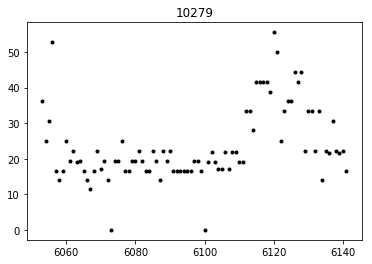

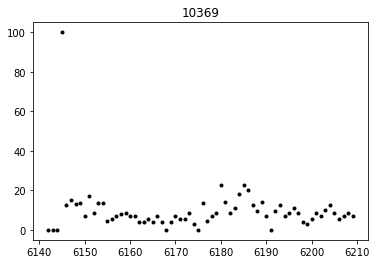

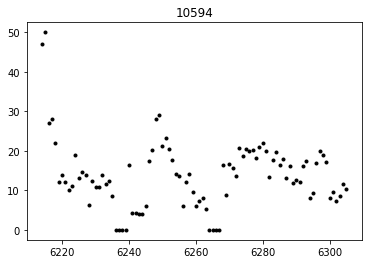

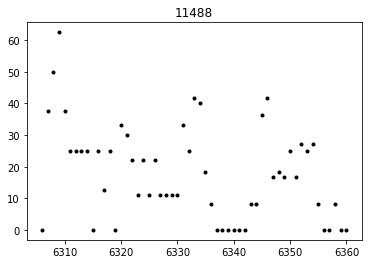

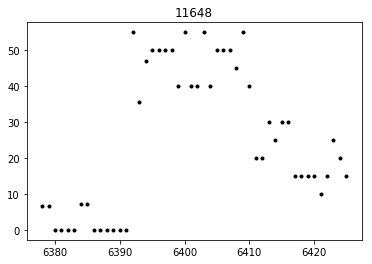

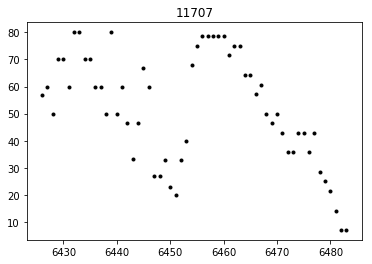

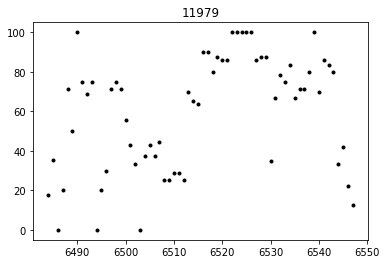

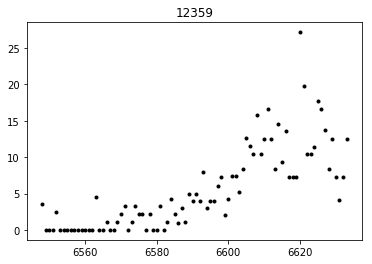

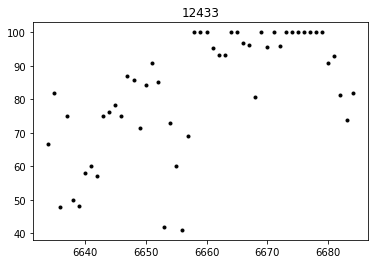

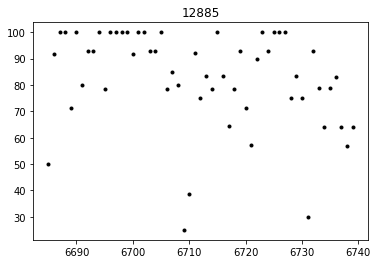

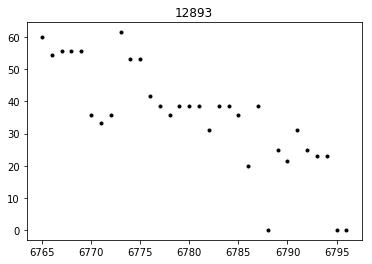

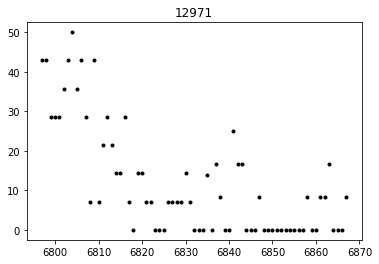

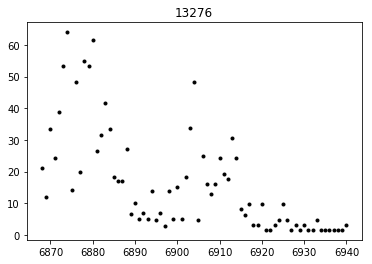

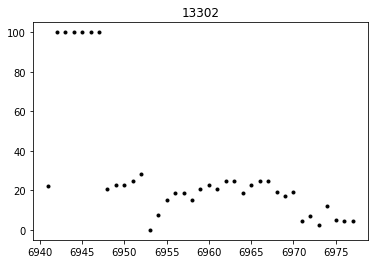

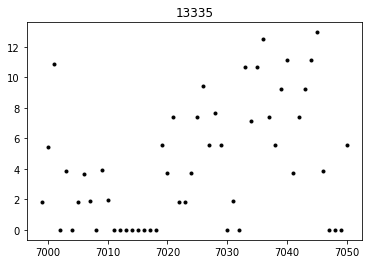

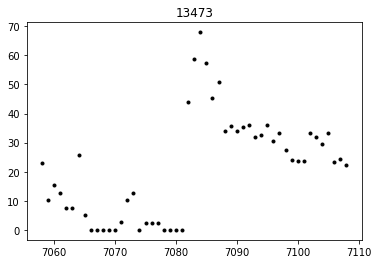

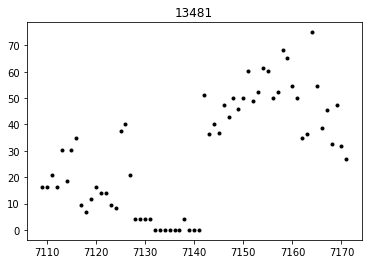

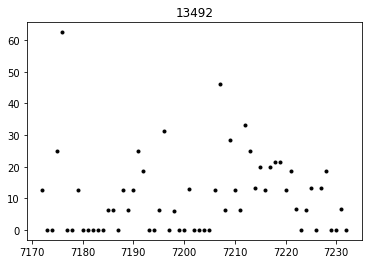

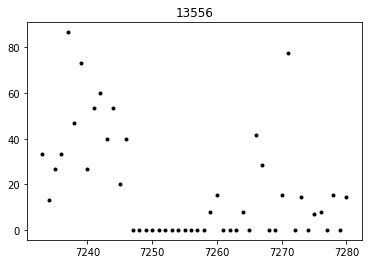

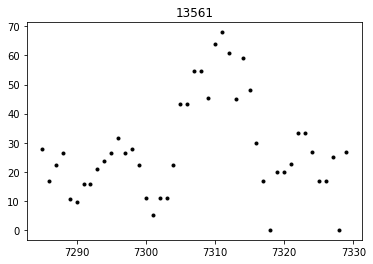

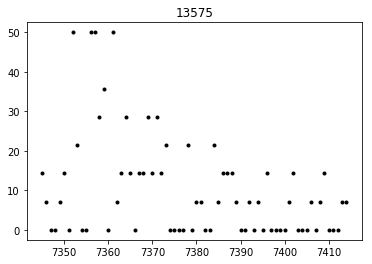

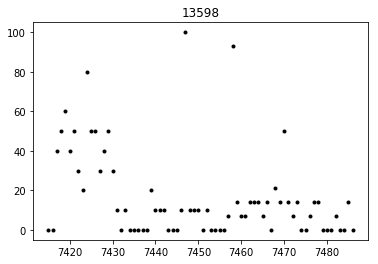

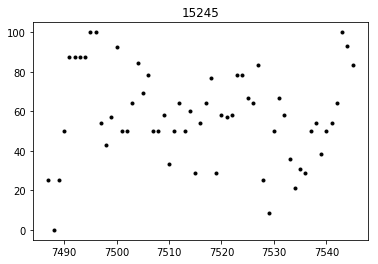

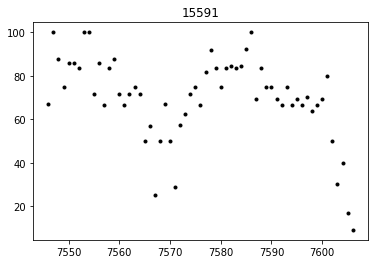

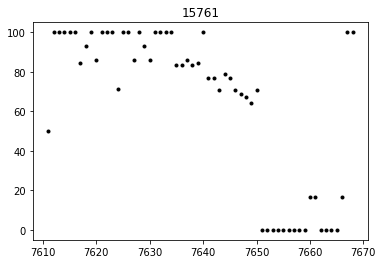

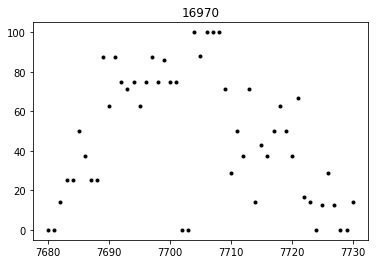

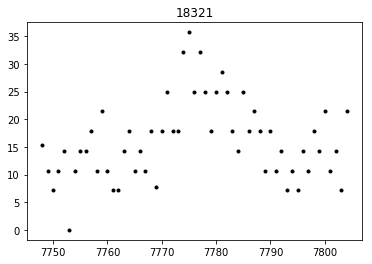

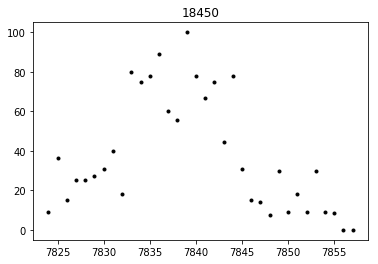

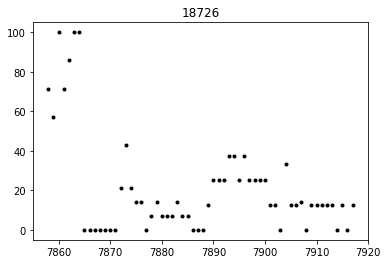

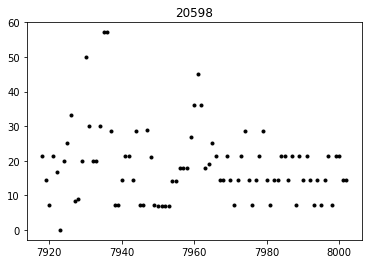

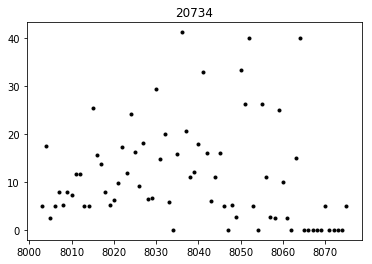

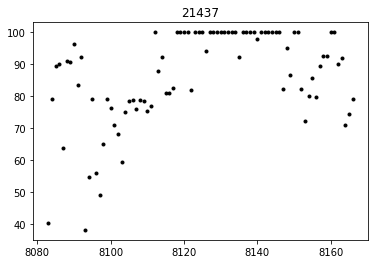

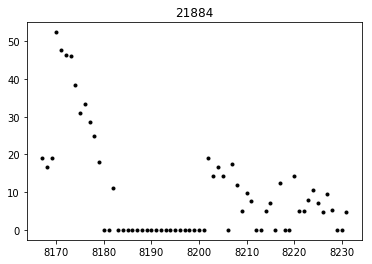

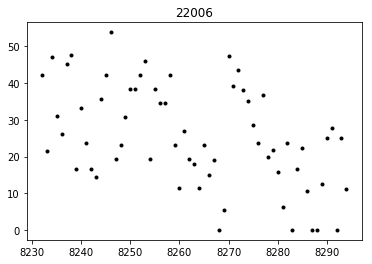

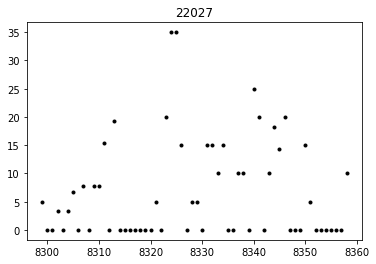

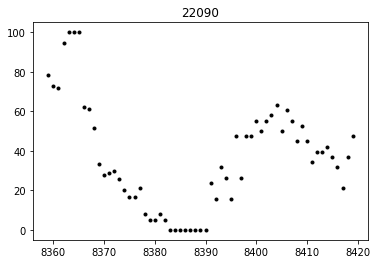

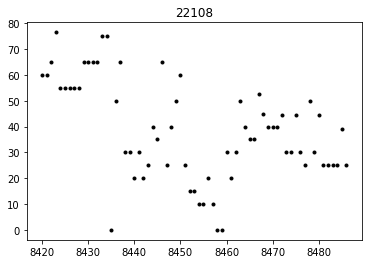

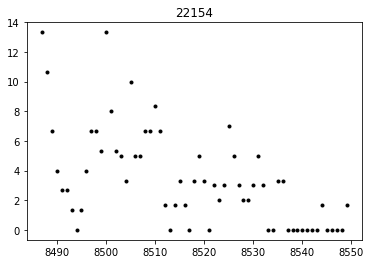

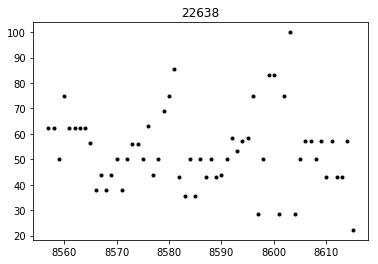

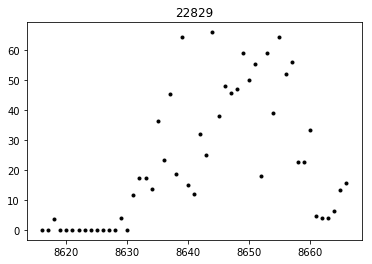

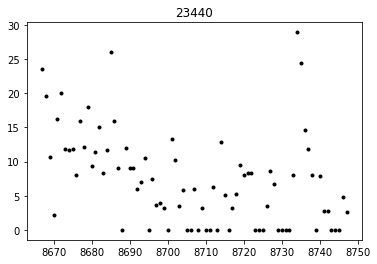

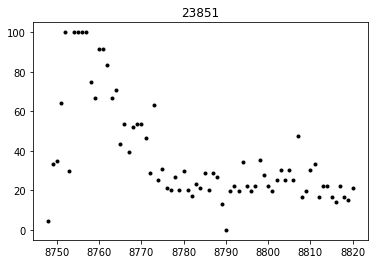

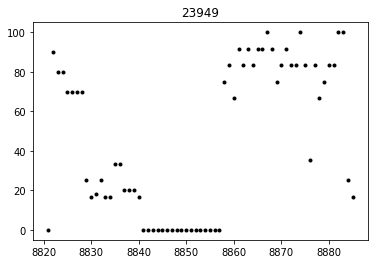

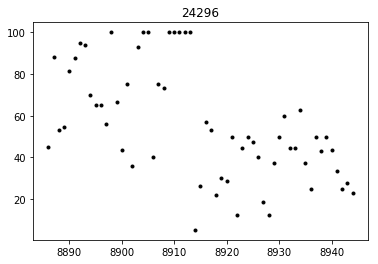

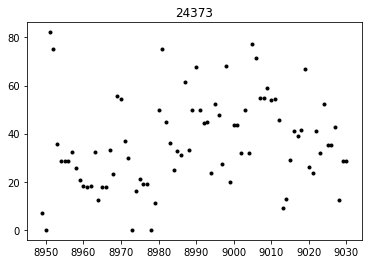

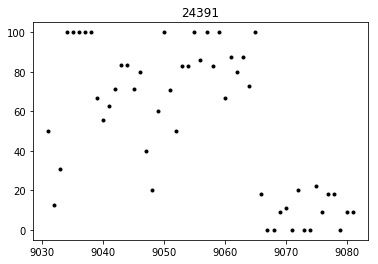

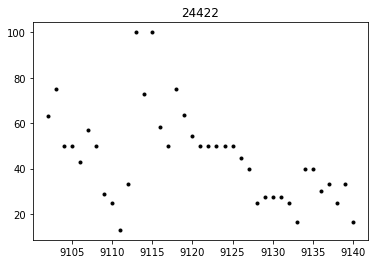

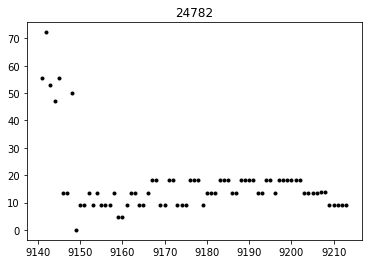

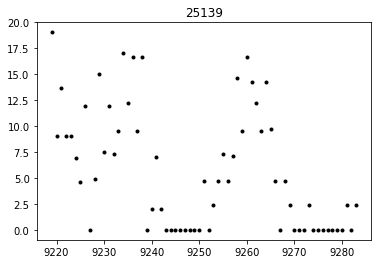

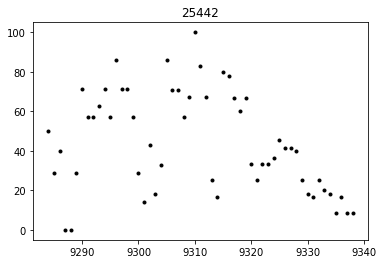

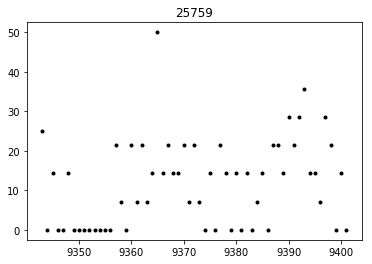

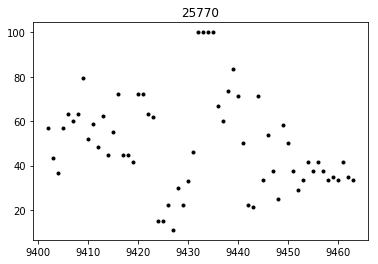

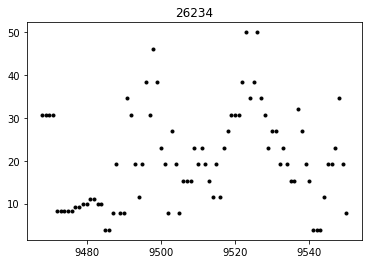

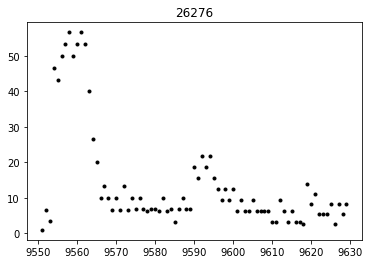

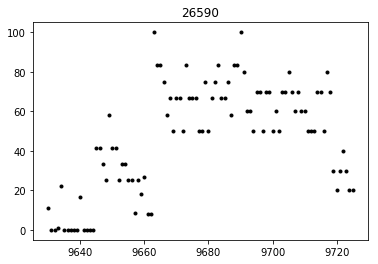

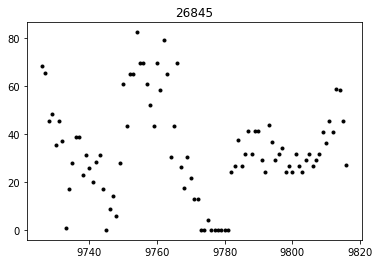

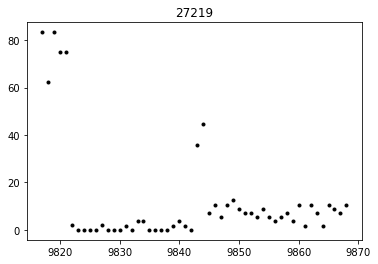

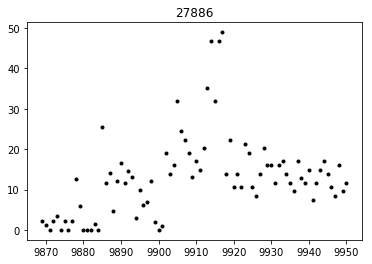

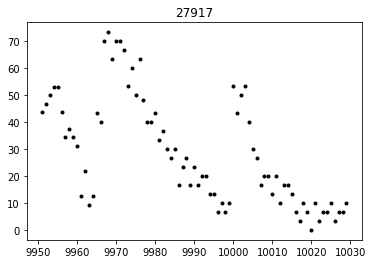

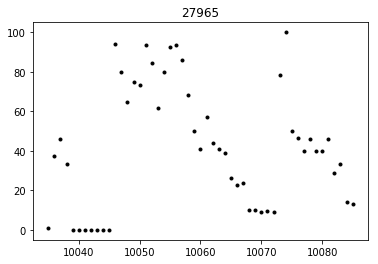

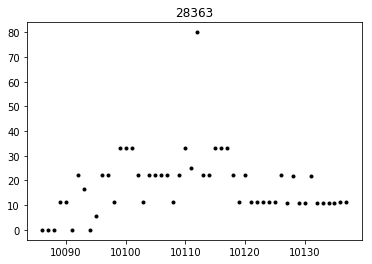

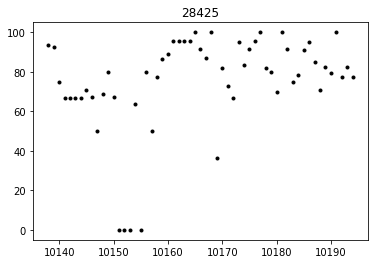

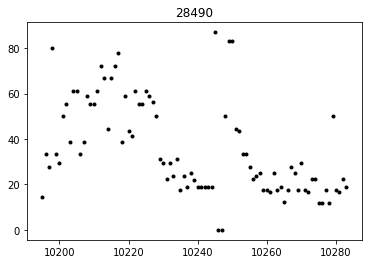

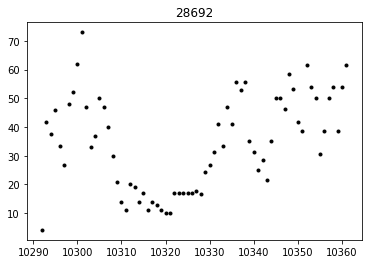

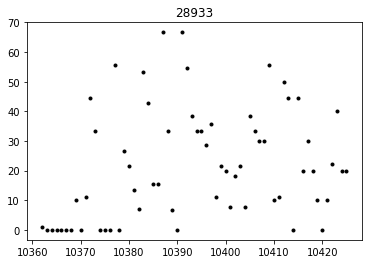

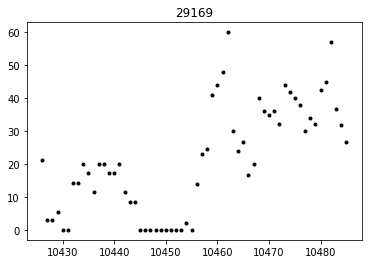

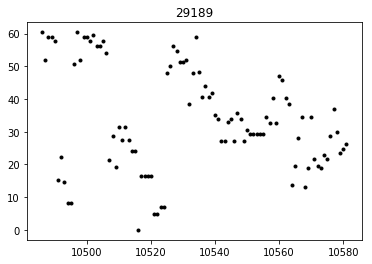

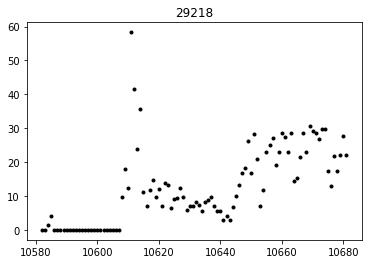

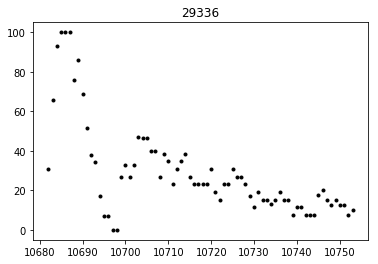

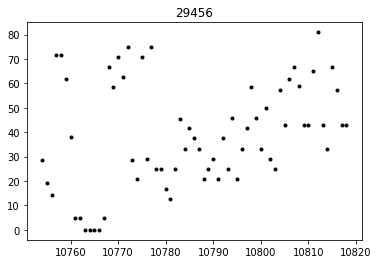

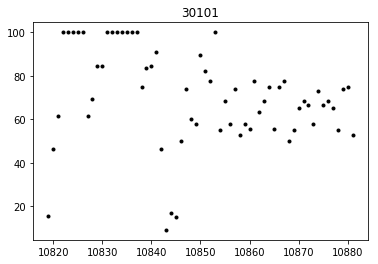

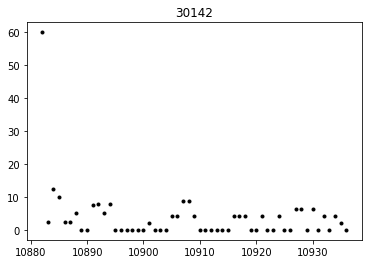

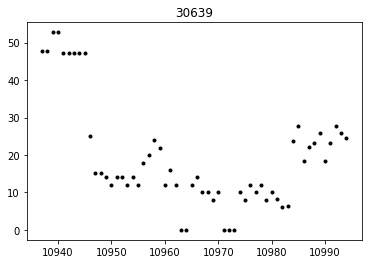

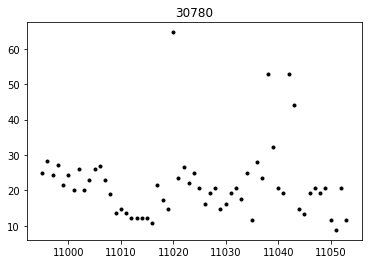

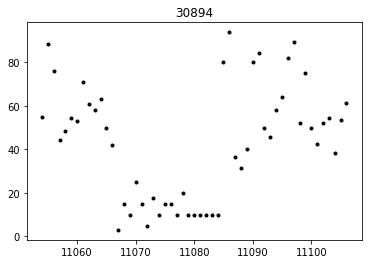

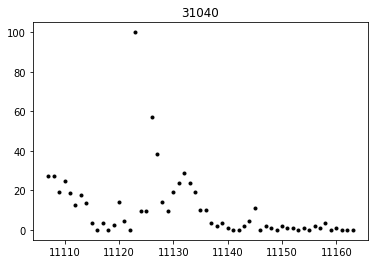

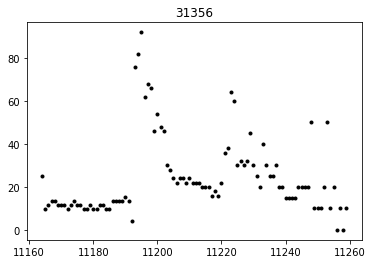

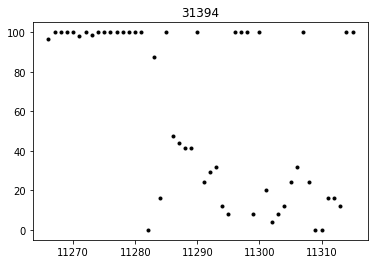

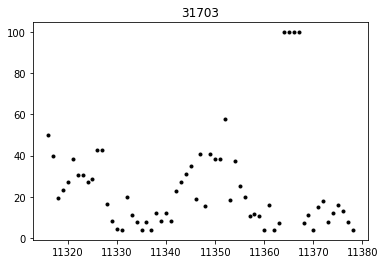

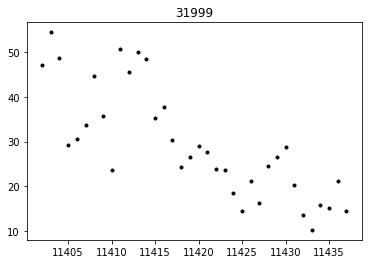

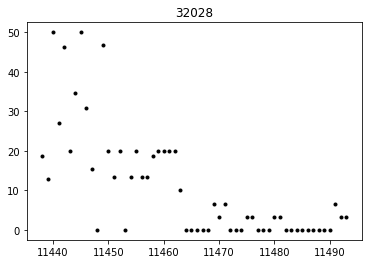

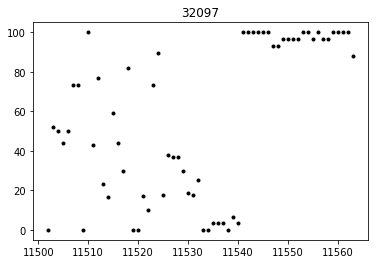

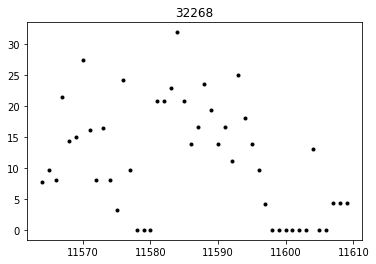

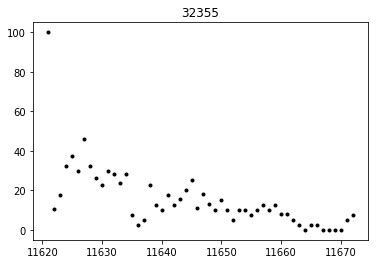

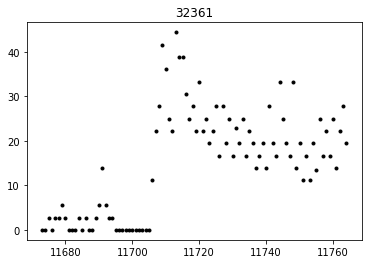

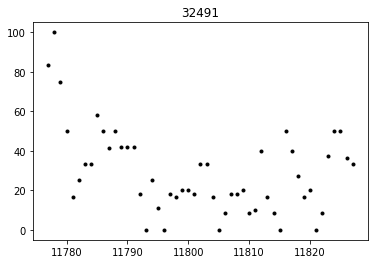

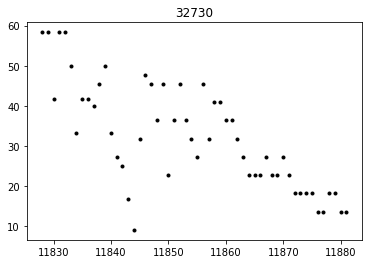

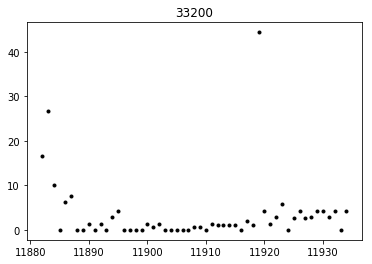

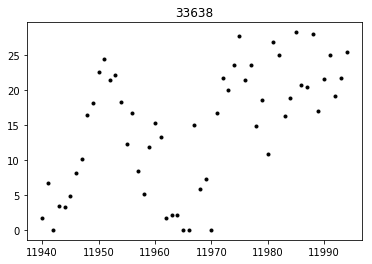

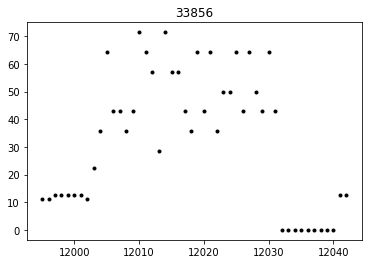

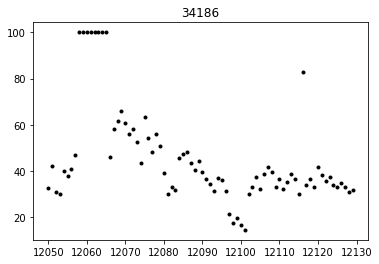

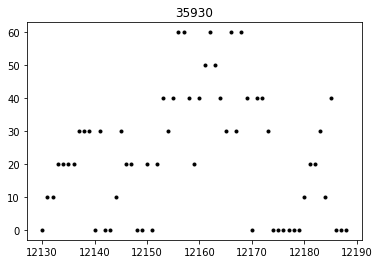

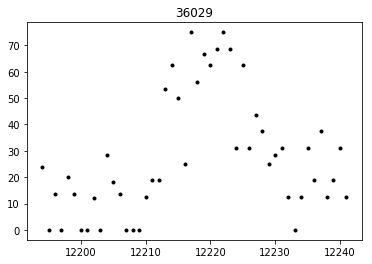

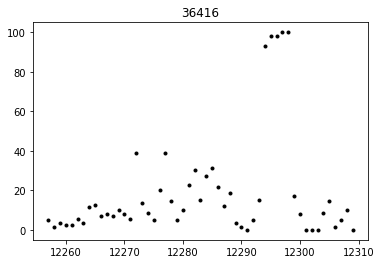

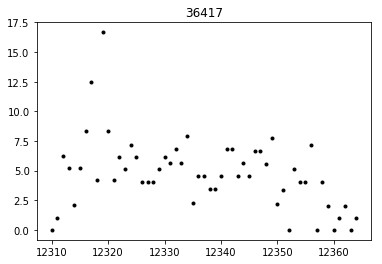

In [103]:
for school in recurring_df['id'].unique().tolist():
    df_school = recurring_df[recurring_df['id']==school]
    df_school['value'].plot(style='k.')
    plt.title(school)
    plt.set_ylim=(0, 100)
    plt.show()

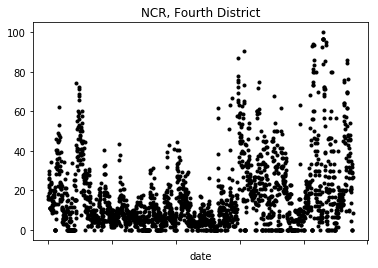

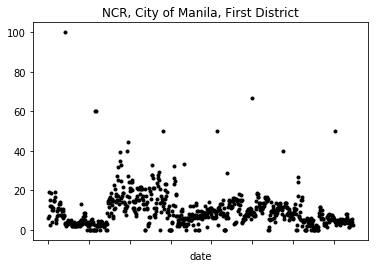

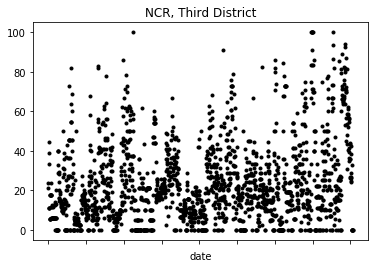

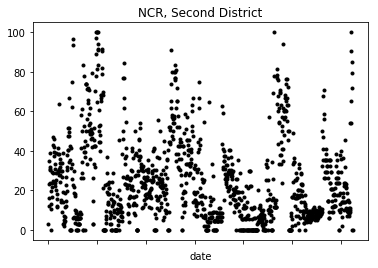

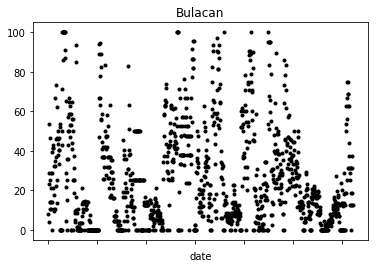

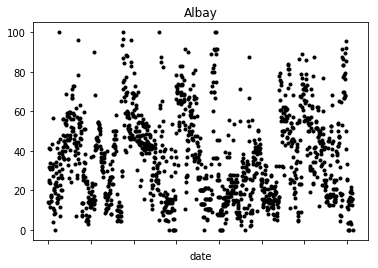

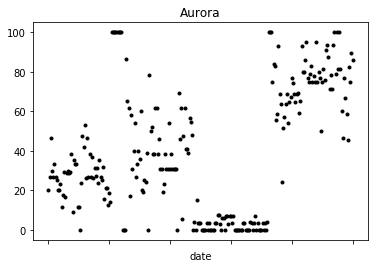

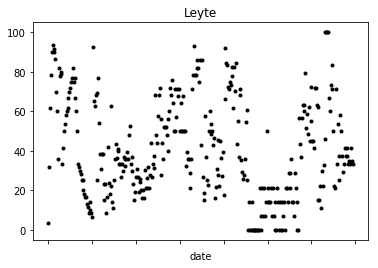

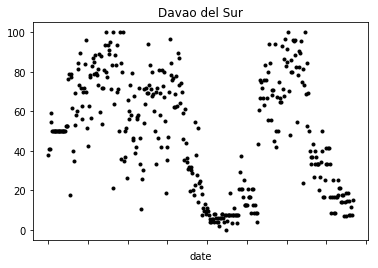

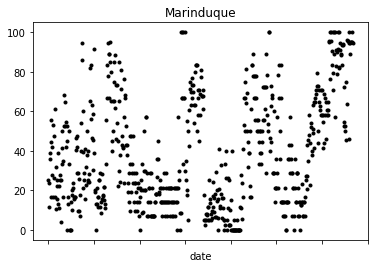

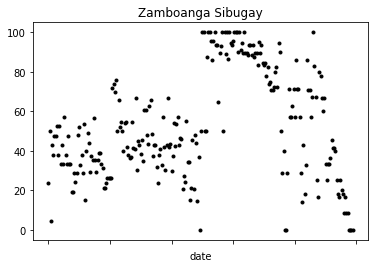

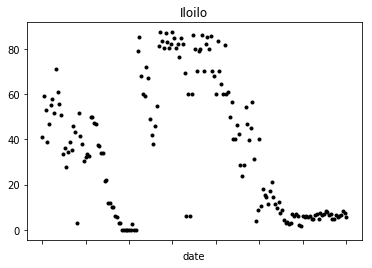

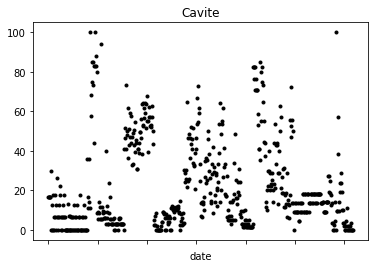

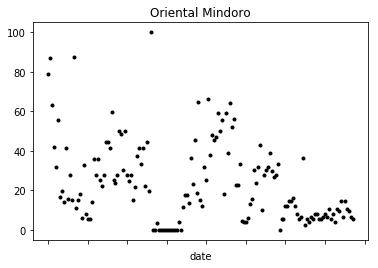

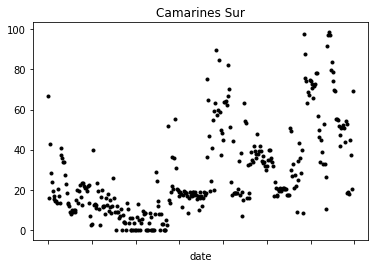

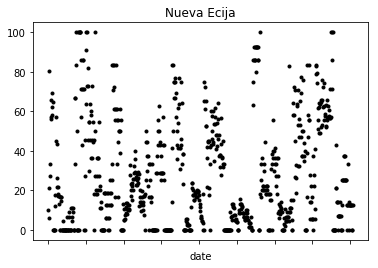

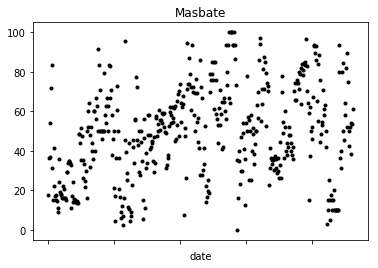

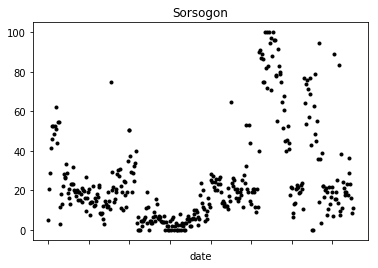

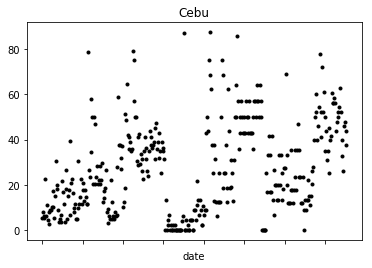

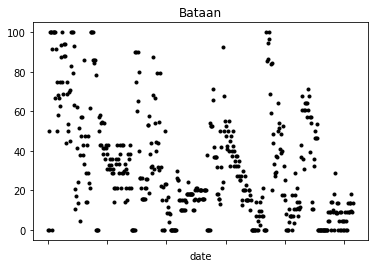

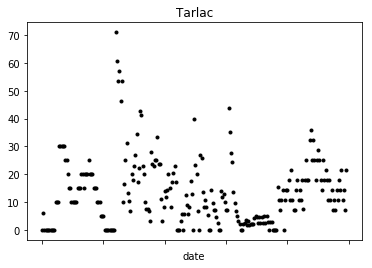

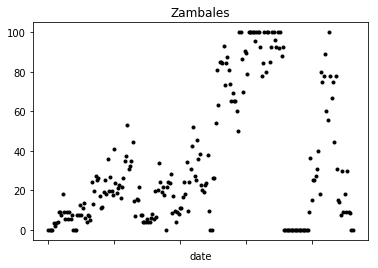

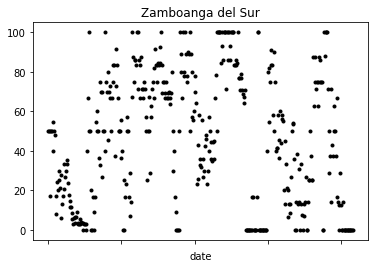

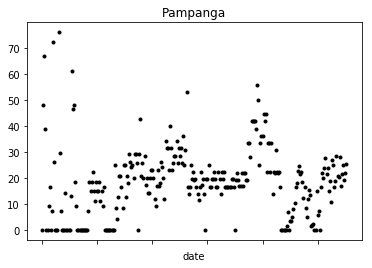

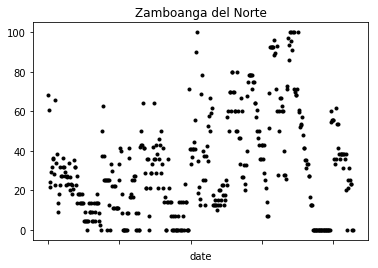

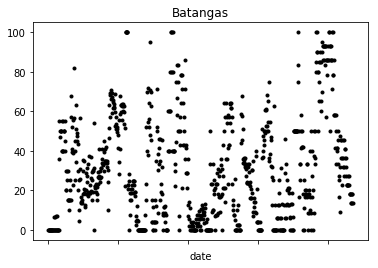

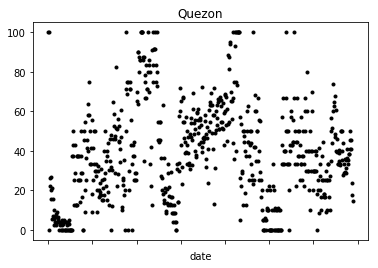

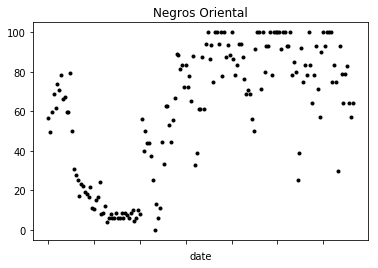

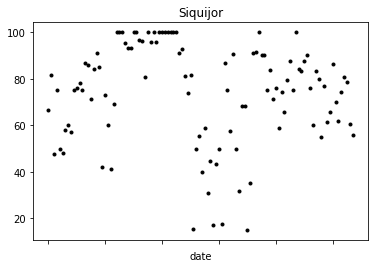

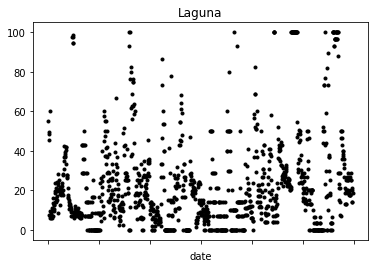

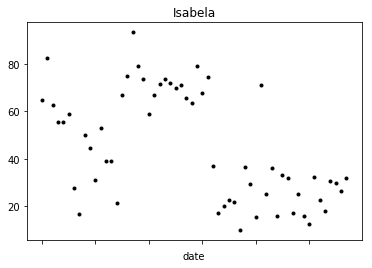

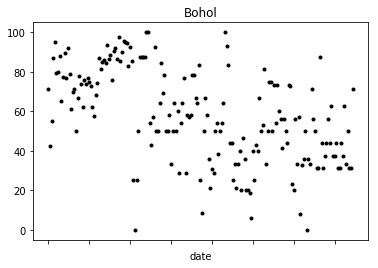

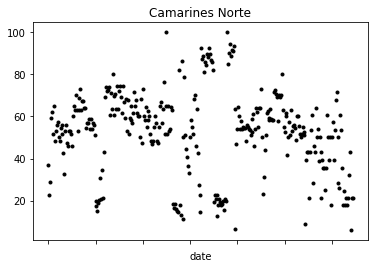

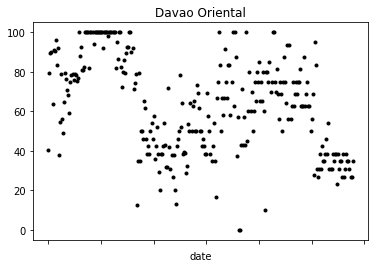

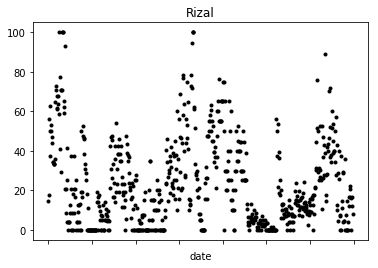

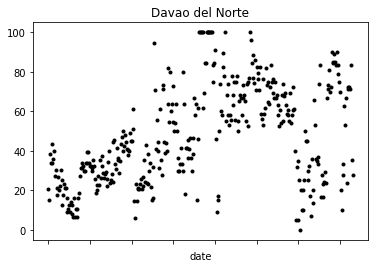

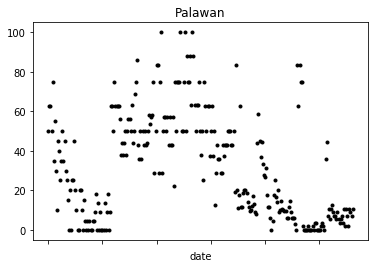

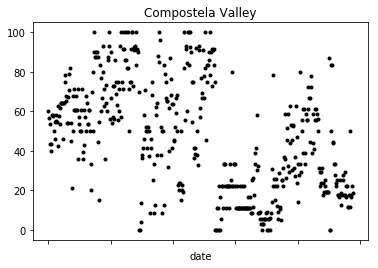

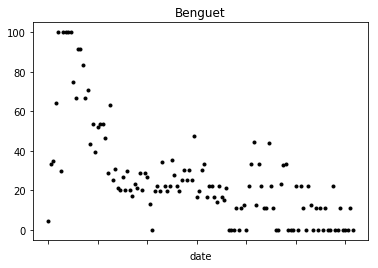

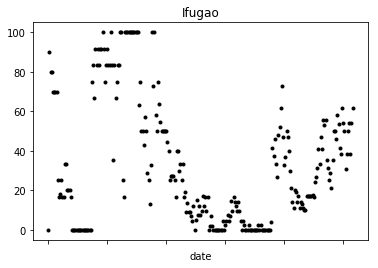

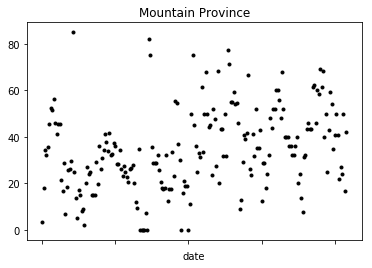

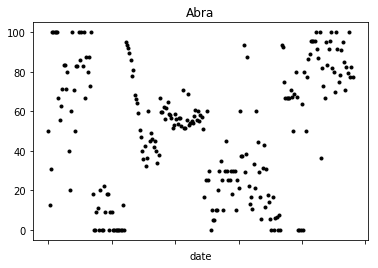

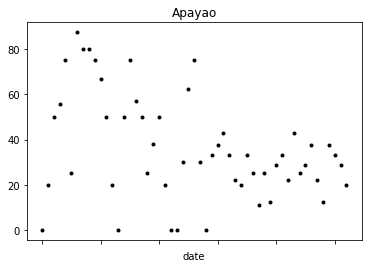

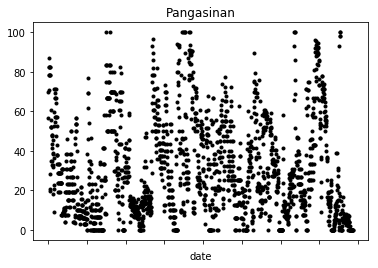

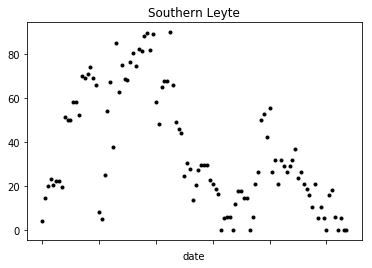

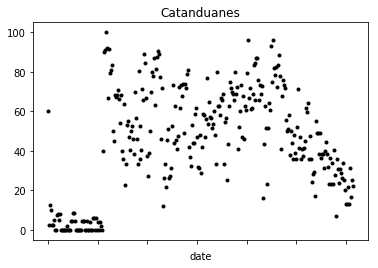

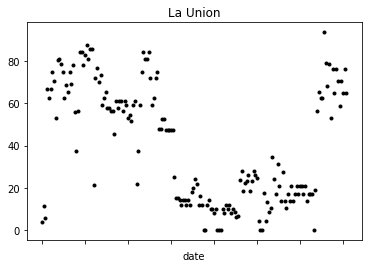

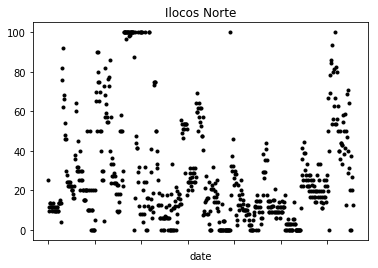

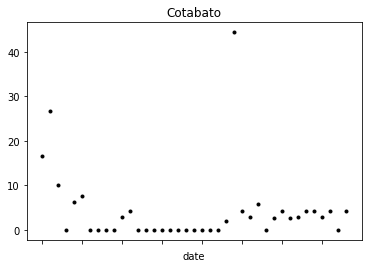

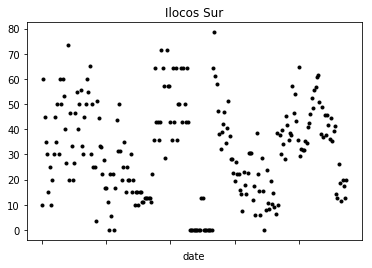

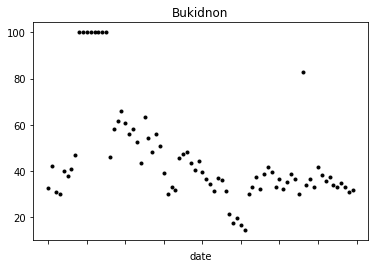

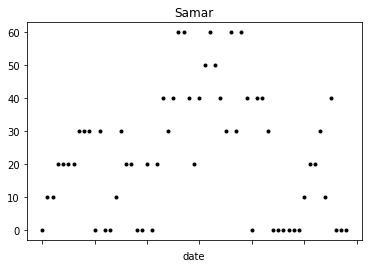

Number of missing provinces:  0


In [12]:
from matplotlib import pyplot as plt

# Plot reported OviTrap index per province, some provinces are not included and are reported as an exception
#semifiltered_df = semifiltered_df[['date', 'id', 'value', 'adm']]
# List of provinces
adm_list = df['adm'].unique().tolist()
i = 0
for province in adm_list:
    df_test = semifiltered_df[semifiltered_df['adm']==province]
    df_test = df_test.set_index(['date'])
    try:
        df_test['value'].plot(style='k.')
        plt.title(province)
        plt.show()
    except:
        print("An exception occurred")
        i= i +1 
print('Number of missing provinces: ', i)

In [107]:
# School plots

# from matplotlib import pyplot as plt
# %matplotlib inline
# # Plot OviTrap index per school for a certain district

# df_test = df[df['adm']=='NCR, Fourth District']
# df_test = df_test.set_index(['date'])

# for school in df_test['id'].unique().tolist():
#     df_school = df_test[df_test['id']==school]
#     df_school['value'].plot(style='k.')
#     plt.title(school)
#     plt.set_ylim=(0, 100)
#     plt.show()

In [40]:
zeros_df[((zeros_df['75%']==0) & (zeros_df['max']==100))]
zeros_df[(zeros_df['75%']==zeros_df['max'])]
zeros_df[((zeros_df['mean']<2)&(zeros_df['max']>50))]

       count       mean        std  min  25%  50%  75%    max
id                                                           
6736    50.0  18.999800  38.540211  0.0  0.0  0.0  0.0  100.0
10166   74.0   3.468378  12.302458  0.0  0.0  0.0  0.0  100.0
23092   82.0   1.219512  11.043153  0.0  0.0  0.0  0.0  100.0
32580   53.0   9.433962  29.509783  0.0  0.0  0.0  0.0  100.0
       count    mean        std  min  25%  50%   75%   max
id                                                        
32609   48.0  15.625  23.420872  0.0  0.0  0.0  50.0  50.0
